# Documentation for Hydra Multi-Asset Verification Test

## Model Description

The methodology for the tests is to create two universes - one for Hydra and one for Uniswap - to subsequently be able to represent sequences of actions on each side. As the Hydra system is unique in its design and has no counterpart yet for approprate comparisons the role of the benchmark will be fulfilled by assembling several Uniswaps together in a way that everything that can be done in Hydra can be accordingly reproduced. This allows next to compare the implications on both systems and ultimately assess the quantitative and qualitative differences of results and impacts on the Hydra system and its agents. 

This approach necessitates the definition and specification of two models:
   - 1 Hydra Omnipool model with one instance that is defined in line with the [Hydra Mathematical Specification](https://hackmd.io/M7OeWimITKGVxBDHGQa6gQ?view)
   - 1 Uniswap model with several instances that each are responsible for a particular mechanism
        - which of 1 instance is used for liquidity provision in asset $R_i$: this is modeled as a Uniswap of $R_i$ and $Q$
        - which of 1 instance is used for liquidity provision in asset $R_j$: this is modeled as a Uniswap of $R_j$ and $Q$
        - which of 1 instance is used for swaps between assets $R_i$ and $R_j$: this is modeled as a Uniswap of $R_i$ and $R_j$
        
![](https://i.imgur.com/yb6Zh3T.png)
        
## Test cases

A variety of testcases can be explored with this model resulting from a combination of the following parameters
   
   - Event: Add Liquidity, Remove Liquidity, Swap Asset, Swap Asset for Base
   - Asset: $R_i$, $R_j$, $R_k$, $Q$
   - Multiple Action Type: Alternating, $i$ only, $j$ only
   - Composite Action Type: Alternating, Trade Bias
   - Enable Symmetric Liquidity: True, False
    
In addition to these settings also a fee structure can be imposed:

   - Fixed Fee

## Test agents

The model specifies a number of eight agents that each have their local balances, can interact with the system and are modeled to be responsible for **one action only**. This allows to track for each testcase how the balances will develop and to show independently which events will trigger changes to local and global states. Most importantly directly and indirectly affected variables can be easily identified.

Two dataframes of agents are initialized identically for both the Uniswap and the Hydra world and then work their way through on each side according to the testcase. Afterwards the effects on both sides can be compared.

![](https://i.imgur.com/r9IAJMr.png)



## Composite Action Tests

Besides being able to test all mechanisms individually also compositions of actions can be performed. This means selecting and combining two from the above testcases and letting the respective agents take the actions repeadetly. A composition action test therefore is defined as two actions which each can be a combination of *event* and *asset* selected from the list of testcases above, for example:
- Add liquidity in $R_i$ and Add liquidity in $R_j$
- Add liquidity in $R_i$ and Swap $R_i$ for $Q$
- Remove liquidity in $R_j$ and Swap $R_i$ for $Q$
- ...

In total there would be 28 composit pairs which can be derived from this decision tree:
selecting any one of the four primitive mechanisms of: **trade in/out** or **add/remove liquidity** of some given asset and then the subsequent action could be the three remaining mechanisms of the same asset or doing anyone of the four mechanisms in another asset.  

These basic combinations can be explored before further proceeding with
- trade sizes,
- trade frequencies,
- randomization,...



# Testcase in this notebook


This notebook documents the results of the following experiment:
- **Action 1**: One agent adds liquidity in XX
- **Action 2**: Another agent trades XX for XX.

which is a reslt of the following settings:

- exo_trade = ['test_q_for_r'] # agent 0
- exo_liq = ['test_add'] # agent 3
- exo_asset = ['alternating']
- exo_composite = ['alternating'] 

## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap (https://github.com/Uniswap/uniswap-v1/blob/master/contracts/uniswap_exchange.vy):
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

## Introduction to Hydra
>Hydra is an automated market maker that generalizes the concept of Uniswap and Balancer to a) an arbitrary number of dimensions and b) a variant weight distaribution of assets in the pool that changes in accordance with action sequences in the pool. Anyone can become a liquidity provider, and invest in the 'Omnipool'. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://hydradx.io/

There is a predefined set of (_mechanisms_) in which an agent can interact with an the Hydra Protocol :
1. `addLiquidity`: deposit a risk asset in the omnipool; mint HDX tokens - "shares" of this risk asset - in exchange;
1. `removeLiquidity`: burn HDX tokens; withdraw a proportional amount of the risk asset in exchange;
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" 
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Hydra takes the corresponding amount of "token A" from the user account 



## Model File structure

The folder **model** contains:

 - a file config.py: 

    This file configures the simulation experiments by setting the number of monte carlo runs, the number of timesteps for the simulation and the simulation parameters. It also aggregates the partial states and the initial state variables.
    
    The purpose of this file is to *configure and initialize* the experiment.
    
    
 - a file partial_state_update_block.py

    This file defines each partial state update block individually. This feature allows cadCAD to divide each simulation timestep into several 'blocks' where different state variables are mutated conditioned upon the policy input.
    
    In the current setting 
    - the first block maps the user action to the appropriate mechanism in the uniswap world
    - the second block maps the user action to the appropriate mechanism in the hydra world
    - the third block resolves the quantities of HDX and weights in the hydra world
    - the forth block calculates the metrics: the swap prices in the uniswap world and the pool prices in the hydra world

    This file corresponds to the system specification diagram, where each column is one partial state update block 
    
    The purpose of this file is to *define* the sequence and details of state updates for each simulation timestep. The relevant mechanisms are imported from the files in the **parts** folder
    
    
 - a file plot_utils.py

    This file defines all plot functions that can be called in the jupyter notebook to visualize the results. In general there are three types of plots:
    - plots related to the uniswap world (do not contain the word 'hydra')
    - plots related to the hydra world (contain the word 'hydra')
    - general plots applicable to both worlds (f.e Impermanent Loss)

    It also can be distinguished between plots related to global system variables and local agent variables:
    - global variables (do not contain the word 'agent')
    - local variables (contain the word 'agent')

    The purpose of this file is to *define* the way how particular properties can be plotted over time.
    

 - a file run.py

    This file *defines* the run and postprocessing methods and is used to execute the simulation run:
    - run() is used to execute the simulation and create a dataframe
    - postprocessing is used to extract relevant metrics from the simulation output in the dataframe

     The purpose of this file is to *execute* the simulation and *create* metrics.
     
     
 - a file state_variables.py

    This file *sets* the number of agents and *defines* the local (agent-level) state variables, *sets* the number of assets and *defines* the global (system-state) variables of the system, *computes* the prices of the assets and *defines* the initial state object
    - the agent states describe their holdings of assets that agents have contributed to the pool or still hold outside as well as their quantities of shares they received for their contribution
    - the global states describe the quantities of assets in the system
    - price variables are computed from the states both in the uniswap and hydra world
    - the initial state object consists of 
        - two agent dataframes, one for each world respectively
        - two sets of global variables, one for each world respectively
        - prices for each world (? is pool = prices ?)

    The purpose of this file is to *define* the global and local states of the system.
    
    
 - a file sys_params.py

    This file *contains* the system parameters and allows to select items from a list for them. Following parameters can be defined:
    - trade action type
    - liquidity action type
    - multiple asset action type
    - composite action type
    - liquidity add type (symmetry)

    In addition the following is set
    - initial values for assets 
    - hard coded fee value
    - choice of the system parameters from the list above
    

 - a folder **parts** which itself contains general files relevant for both instances, files related specifically to Uniswap and files related specifically to Hydra 
      - [action.py](model/parts/action.py)
       This is an action dictionary which drives the model. As there are no behavioral assumptions in the model yet, currently actions are prescribed actions in testing mode derived from events. However, action schema respects https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange as much as possible, allowing for future analysis against uniswap transaction datasets.
        This file contains a function called 'actionDecoder' which takes its inputs from the file sys_params.py and maps those encoded events to agent actions. At first an arbitrary action dictionary is defined which then is adapted according to the choices of system parameters. In particular relevant are the parameter definitions of the asset, the composite and whether there is a trade or liquidity event defined.
        
    - [uniswap.py](model/parts/uniswap.py)
     Reads in action output and directs the action to the appropriate Uniswap mechanism for each corresponding Uniswap instance. Currently there are two instances in place, namely the R_i<>Q pair and the R_j<>Q pair. Both instances have their respective requisite state variables: UNI_Qx, UNI_Rx, and UNI_Sx.

    - [utils.py](model/parts/utils.py)
    Computes the state update for each Uniswap state variable and outputs the updated global state variables.
        
     - [agent_utils.py](model/parts/agent_utils.py)
     Computes the corresponding agent local state for each Uniswap agent resolving their action and outputs the updates local state variables.

      -  [hydra.py](model/prts/hydra.py)
     Reads in action output and directs the action to the appropriate Hydra mechanism for each state variable: Q, Sq, and pool.
    
      - [hydra_utils.py](model/parts/hydra_utils.py)
     Computes the state update for each Hydra state variable

    -  [asset_utils.py](model/parts/asset_utils.py)
     Computes the state update for each Reserve Asset in a Hydra Omnipool

    -  [hydra_agent_utils_class.py](model/parts/hydra_agent_utils_class.py)
     Computes the corresponding agent local state for each Hydra agent resolving their action and outputs the updates local state variables.
     
     #### The interrelations between the files are shown here:
     
    ![](https://i.imgur.com/mNhfQE4.png)



## Run Model

The following command lines import all packages, experiments and run the model 

This is the execution of cadcad. This writes the config object, does the execution and returns the rdf - which is a data object that shows the rows and columns of results in a dataframe

Here is one additional option as well. The postprocessing causes the index of the results to be every forth because of the cadcad architecture where the partial state updates are the substeps. With this option selected we see only the end of each timestep - the last substep. Therefore only final results are shown. To get a line for each substep the postprocessing needs to be deactivated. 

In [1]:
# Dependences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiments
from model import run
from model.parts.utils import *
from model.plot_utils import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

df = run.run()
rdf = run.postprocessing(df)
# rdf = df # debugging substeps



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (500, 10, 1, 19)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Q Swap
Q 400000000
delta Q 0.0
H Swap
H 400000000
delta Q 0.0
delta_Ri 50
Ri 100000000
Si 1000
delta_Si -0.5
Q Swap
Q 400000000.0
delta Q -200.1001000500491
H Swap
H 400000000.0
delta Q -200.1001000500491
delta_Ri 100
Ri 99999950.0
Si 1000.5
delta_Si -1.0010007505003753
Q Swap
Q 399999799.89989996
delta Q -100.15020030049725
H Swap
H 399999799.89989996
delta Q -100.15020030049725
delta_Ri 50
Ri 99999949.89984988
Si 1000.5000002500001
delta_Si -0.5005003760015648
Q Swap
Q 399999699.74969965
delta Q 0.10019979947983869
H Swap
H 

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 400001175.4817646
delta Q -799.7820104352904
H Swap
H 400001175.4817646
delta Q -799.7820104352904
delta_Ri 50
Ri 99999601.99042903
Si 1003.9859567032518
delta_Si -0.5039959065806173
Q Swap
Q 400000375.6997542
delta Q 1387.5580908839559
H Swap
H 400000375.6997542
delta Q 1387.5580908839559
delta_Ri 100
Ri 100000348.19761035
Si 996.5199177021001
delta_Si -0.9930484886058932
Q Swap
Q 400001763.25784504
delta Q -899.5254284404731
H Swap
H 400001763.25784504
delta Q -899.5254284404731
delta_Ri 50
Ri 99999552.68490897
Si 1004.4819470757315
delta_Si -0.5044942476794295
Q Swap
Q 400000863.7324166
delta Q 1583.7933495422617
H Swap
H 400000863.7324166
delta Q 1583.7933495422617
delta_Ri 100
Ri 100000397.7473928
Si 996.0268658340315
delta_Si -0.992065571548218
Q Swap
Q 400002447.5257662
delta Q -999.2175570694762
H Swap
H 400002447.5257662
delta Q -999.2175570694762
delta_Ri 50
Ri 99999503.47760665
Si 1004.977437366348
delta_Si -0.5049923322077301
Q Swap
Q 400001448.3082091
delta Q 1779

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 400012508.5749282
delta Q 3710.475927891289
H Swap
H 400012508.5749282
delta Q 3710.475927891289
delta_Ri 100
Ri 100000939.50744623
Si 990.6676091100995
delta_Si -0.9814130912908501
Q Swap
Q 400016219.0508561
delta Q -2092.41839097667
H Swap
H 400016219.0508561
delta Q -2092.41839097667
delta_Ri 50
Ri 99998968.61034076
Si 1010.3948992354717
delta_Si -0.5104541909722704
Q Swap
Q 400014126.6324651
delta Q 3900.949828422596
H Swap
H 400014126.6324651
delta Q 3900.949828422596
delta_Ri 100
Ri 100000988.46016337
Si 990.1861881178261
delta_Si -0.9804589956927203
Q Swap
Q 400018027.58229357
delta Q -2191.487583603003
H Swap
H 400018027.58229357
delta Q -2191.487583603003
delta_Ri 50
Ri 99998920.5628178
Si 1010.8844087893343
delta_Si -0.5109491593418891
Q Swap
Q 400015836.09471
delta Q 4090.953424717882
H Swap
H 400015836.09471
delta Q 4090.953424717882
delta_Ri 100
Ri 100001037.36329372
Si 989.7057208435572
delta_Si -0.979507252821765
Q Swap
Q 400019927.0481347
delta Q -2290.50425347

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 400043832.28405344
delta Q -3277.762031436562
H Swap
H 400043832.28405344
delta Q -3277.762031436562
delta_Ri 50
Ri 99998398.26557957
Si 1016.2362904197425
delta_Si -0.5163763699610964
Q Swap
Q 400040554.522022
delta Q 6150.372450398272
H Swap
H 400040554.522022
delta Q 6150.372450398272
delta_Ri 100
Ri 100001572.0325152
Si 984.4828585603277
delta_Si -0.9691912627973286
Q Swap
Q 400046704.8944724
delta Q -3376.194924778189
H Swap
H 400046704.8944724
delta Q -3376.194924778189
delta_Ri 50
Ri 99998351.34396836
Si 1016.7198571748307
delta_Si -0.5168681553648231
Q Swap
Q 400043328.69954765
delta Q 6334.846297204028
H Swap
H 400043328.69954765
delta Q 6334.846297204028
delta_Ri 100
Ri 100001620.34265803
Si 984.0136544782713
delta_Si -0.9682671829534736
Q Swap
Q 400049663.54584485
delta Q -3474.574208594531
H Swap
H 400049663.54584485
delta Q -3474.574208594531
delta_Ri 50
Ri 99998304.51469406
Si 1017.2029304339054
delta_Si -0.51735967259889
Q Swap
Q 400046188.97163624
delta Q 6518.

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 400072123.12985754
delta Q 7974.961524049272
H Swap
H 400072123.12985754
delta Q 7974.961524049272
delta_Ri 100
Ri 100002052.92122477
Si 979.8321146899173
delta_Si -0.9600512638815502
Q Swap
Q 400080098.0913816
delta Q -4357.560869491323
H Swap
H 400080098.0913816
delta Q -4357.560869491323
delta_Ri 50
Ri 99997887.16936845
Si 1021.5284270308714
delta_Si -0.5217711877575648
Q Swap
Q 400075740.5305121
delta Q 8154.983138478209
H Swap
H 400075740.5305121
delta Q 8154.983138478209
delta_Ri 100
Ri 100002100.74014606
Si 979.3720468094459
delta_Si -0.9591494568340232
Q Swap
Q 400083895.5136506
delta Q -4455.399255064535
H Swap
H 400083895.5136506
delta Q -4455.399255064535
delta_Ri 50
Ri 99997841.25116211
Si 1022.0065802156403
delta_Si -0.5222599992836993
Q Swap
Q 400079440.11439556
delta Q 8334.567093976586
H Swap
H 400079440.11439556
delta Q 8334.567093976586
delta_Ri 100
Ri 100002148.51009378
Si 978.9128803556204
delta_Si -0.9582498392316176
Q Swap
Q 400087774.6814895
delta Q -455

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 400135732.57493407
delta Q -5625.180027458799
H Swap
H 400135732.57493407
delta Q -5625.180027458799
delta_Ri 50
Ri 99997297.18233784
Si 1027.7062373898839
delta_Si -0.5281043288821119
Q Swap
Q 400130107.3949066
delta Q 10455.924865715026
H Swap
H 400130107.3949066
delta Q 10455.924865715026
delta_Ri 100
Ri 100002717.93946801
Si 973.4724039135299
delta_Si -0.9476227653680389
Q Swap
Q 400140563.3197723
delta Q -5722.302592598194
H Swap
H 400140563.3197723
delta Q -5722.302592598194
delta_Ri 50
Ri 99997252.41590042
Si 1028.1780354506984
delta_Si -0.5285895597343242
Q Swap
Q 400134841.0171797
delta Q 10629.940597844366
H Swap
H 400134841.0171797
delta Q 10629.940597844366
delta_Ri 100
Ri 100002765.075249
Si 973.0247591949333
delta_Si -0.9467510036286867
Q Swap
Q 400145470.95777756
delta Q -5819.369520903739
H Swap
H 400145470.95777756
delta Q -5819.369520903739
delta_Ri 50
Ri 99997207.73657067
Si 1028.6493465975818
delta_Si -0.5290745122819364
Q Swap
Q 400139651.58825666
delta Q 

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 400204426.92280084
delta Q -6883.410969936255
H Swap
H 400204426.92280084
delta Q -6883.410969936255
delta_Ri 50
Ri 99996721.95355912
Si 1033.8017130921587
delta_Si -0.5343905085651873
Q Swap
Q 400197543.5118309
delta Q 12685.797688180657
H Swap
H 400197543.5118309
delta Q 12685.797688180657
delta_Ri 100
Ri 100003326.92264132
Si 967.72039497556
delta_Si -0.9364516078310878
Q Swap
Q 400210229.3095191
delta Q -6979.804086654109
H Swap
H 400210229.3095191
delta Q -6979.804086654109
delta_Ri 50
Ri 99996678.30335435
Si 1034.2672031798656
delta_Si -0.5348720906150433
Q Swap
Q 400203249.5054325
delta Q 12854.46291683541
H Swap
H 400203249.5054325
delta Q 12854.46291683541
delta_Ri 100
Ri 100003373.42894134
Si 967.2839164379108
delta_Si -0.9356066129752041
Q Swap
Q 400216103.96834934
delta Q -7076.140548209267
H Swap
H 400216103.96834934
delta Q -7076.140548209267
delta_Ri 50
Ri 99996634.73758183
Si 1034.73221001681
delta_Si -0.5353533892695495
Q Swap
Q 400209027.8278011
delta Q 13022

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 400277264.9990228
delta Q 14847.368117673514
H Swap
H 400277264.9990228
delta Q 14847.368117673514
delta_Ri 100
Ri 100003927.75110483
Si 962.1114815541105
delta_Si -0.9256221468041478
Q Swap
Q 400292112.3671405
delta Q -8227.731626503646
H Swap
H 400292112.3671405
delta Q -8227.731626503646
delta_Ri 50
Ri 99996118.46130651
Si 1040.2747024283954
delta_Si -0.5411067315234004
Q Swap
Q 400283884.63551396
delta Q 15010.890034364402
H Swap
H 400283884.63551396
delta Q 15010.890034364402
delta_Ri 100
Ri 100003973.6326961
Si 961.6858274806972
delta_Si -0.9248028825075193
Q Swap
Q 400298895.52554834
delta Q -8323.324768194267
H Swap
H 400298895.52554834
delta Q -8323.324768194267
delta_Ri 50
Ri 99996075.97504145
Si 1040.7334530295514
delta_Si -0.5415843120309823
Q Swap
Q 400290572.20078015
delta Q 15174.024605220866
H Swap
H 400290572.20078015
delta Q 15174.024605220866
delta_Ri 100
Ri 100004019.46643291
Si 961.2609922863797
delta_Si -0.923985556002127
Q Swap
Q 400305746.22538537
delta

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 400355564.8452455
delta Q -9085.98707442946
H Swap
H 400355564.8452455
delta Q -9085.98707442946
delta_Ri 50
Ri 99995739.00877455
Si 1044.3862297826884
delta_Si -0.5453945376932443
Q Swap
Q 400346478.85817105
delta Q 16465.295328239063
H Swap
H 400346478.85817105
delta Q 16465.295328239063
delta_Ri 100
Ri 100004384.41702494
Si 957.8915590458596
delta_Si -0.9175160111631074
Q Swap
Q 400362944.1534993
delta Q -9181.058452743522
H Swap
H 400362944.1534993
delta Q -9181.058452743522
delta_Ri 50
Ri 99995697.25060648
Si 1044.8406777327993
delta_Si -0.5458695083195263
Q Swap
Q 400353763.0950466
delta Q 16624.99558659974
H Swap
H 400353763.0950466
delta Q 16624.99558659974
delta_Ri 100
Ri 100004429.82136996
Si 957.4740072507523
delta_Si -0.9167158656854936
Q Swap
Q 400370388.09063315
delta Q -9276.071508063425
H Swap
H 400370388.09063315
delta Q -9276.071508063425
delta_Ri 50
Ri 99995655.57238783
Si 1045.2946490680984
delta_Si -0.5463441872129262
Q Swap
Q 400361112.0191251
delta Q 167

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 400448312.7654147
delta Q -10222.97933759551
H Swap
H 400448312.7654147
delta Q -10222.97933759551
delta_Ri 50
Ri 99995243.14634123
Si 1049.8082131845279
delta_Si -0.5510748560592985
Q Swap
Q 400438089.78607714
delta Q 18357.132511698066
H Swap
H 400438089.78607714
delta Q 18357.132511698066
delta_Ri 100
Ri 100004926.13627894
Si 952.933310601916
delta_Si -0.9080371633065998
Q Swap
Q 400456446.9185888
delta Q -10317.346374624642
H Swap
H 400456446.9185888
delta Q -10317.346374624642
delta_Ri 50
Ri 99995202.33528222
Si 1050.2569611543336
delta_Si -0.5515463035689763
Q Swap
Q 400446129.5722142
delta Q 18512.394824392893
H Swap
H 400446129.5722142
delta Q 18512.394824392893
delta_Ri 100
Ri 100004970.97176963
Si 952.5252330103052
delta_Si -0.9072592199216365
Q Swap
Q 400464641.9670386
delta Q -10411.654284884435
H Swap
H 400464641.9670386
delta Q -10411.654284884435
delta_Ri 50
Ri 99995161.60195345
Si 1050.705236044808
delta_Si -0.5520174553277631
Q Swap
Q 400454230.3127537
delta Q

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu


Q 400549875.45495534
delta Q -11351.46727609003
H Swap
H 400549875.45495534
delta Q -11351.46727609003
delta_Ri 50
Ri 99994758.50418751
Si 1055.1620310339185
delta_Si -0.5567126359373122
Q Swap
Q 400538523.98767924
delta Q 20196.572888122122
H Swap
H 400538523.98767924
delta Q 20196.572888122122
delta_Ri 100
Ri 100005461.05257334
Si 948.0873015404135
delta_Si -0.8988204462850713
Q Swap
Q 400558720.5605674
delta Q -11445.120572111498
H Swap
H 400558720.5605674
delta Q -11445.120572111498
delta_Ri 50
Ri 99994718.61403666
Si 1055.6051217087067
delta_Si -0.5571805133422488
Q Swap
Q 400547275.4399953
delta Q 20347.552114331964
H Swap
H 400547275.4399953
delta Q 20347.552114331964
delta_Ri 100
Ri 100005505.32345489
Si 947.6884360046101
delta_Si -0.8980639304126631
Q Swap
Q 400567622.9921096
delta Q -11538.713982096015
H Swap
H 400567622.9921096
delta Q -11538.713982096015
delta_Ri 50
Ri 99994678.7994743
Si 1056.0477428863487
delta_Si -0.5576480912008364
Q Swap
Q 400556084.2781275
delta Q 20

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 400656686.7360339
delta Q 22132.281967412364
H Swap
H 400656686.7360339
delta Q 22132.281967412364
delta_Ri 100
Ri 100006032.92772868
Si 942.9605300721311
delta_Si -0.8891209212513148
Q Swap
Q 400678819.0180013
delta Q -12657.141784529145
H Swap
H 400678819.0180013
delta Q -12657.141784529145
delta_Ri 50
Ri 99994206.85740441
Si 1061.3226859391248
delta_Si -0.5632355508831307
Q Swap
Q 400666161.87621677
delta Q 22278.788193649205
H Swap
H 400666161.87621677
delta Q 22278.788193649205
delta_Ri 100
Ri 100006076.59180462
Si 942.5713589928403
delta_Si -0.8883867831551511
Q Swap
Q 400688440.6644104
delta Q -12749.951208648066
H Swap
H 400688440.6644104
delta Q -12749.951208648066
delta_Ri 50
Ri 99994168.00974381
Si 1061.7592311123651
delta_Si -0.5636992073090049
Q Swap
Q 400675690.71320176
delta Q 22424.957312508923
H Swap
H 400675690.71320176
delta Q 22424.957312508923
delta_Ri 100
Ri 100006120.20941415
Si 942.1829216609509
delta_Si -0.8876543315655999
Q Swap
Q 400698115.6705143
de

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 400818278.5742678
delta Q -13950.928021513342
H Swap
H 400818278.5742678
delta Q -13950.928021513342
delta_Ri 50
Ri 99993669.58912541
Si 1067.3920906635685
delta_Si -0.56969900189314
Q Swap
Q 400804327.6462463
delta Q 24294.91914845487
H Swap
H 400804327.6462463
delta Q 24294.91914845487
delta_Ri 100
Ri 100006683.02371201
Si 937.1992465695545
delta_Si -0.8782837318604816
Q Swap
Q 400828622.56539476
delta Q -14042.88232476071
H Swap
H 400828622.56539476
delta Q -14042.88232476071
delta_Ri 50
Ri 99993631.75090897
Si 1067.822149989278
delta_Si -0.5701583811097845
Q Swap
Q 400814579.68307
delta Q 24436.469832330295
H Swap
H 400814579.68307
delta Q 24436.469832330295
delta_Ri 100
Ri 100006725.9939843
Si 936.82090680718
delta_Si -0.8775743858306284
Q Swap
Q 400839016.1529023
delta Q -14134.775138917166
H Swap
H 400839016.1529023
delta Q -14134.775138917166
delta_Ri 50
Ri 99993593.9835662
Si 1068.2517483431604
delta_Si -0.5706174527669079
Q Swap
Q 400824881.3777634
delta Q 24577.6977

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 400941403.4125088
delta Q 26110.16169229211
H Swap
H 400941403.4125088
delta Q 26110.16169229211
delta_Ri 100
Ri 100007238.05733006
Si 932.3356694167966
delta_Si -0.8691868882215915
Q Swap
Q 400967513.5742011
delta Q -15232.673763833178
H Swap
H 400967513.5742011
delta Q -15232.673763833178
delta_Ri 50
Ri 99993146.24530017
Si 1073.371085342428
delta_Si -0.5761022280581223
Q Swap
Q 400952280.9004373
delta Q 26247.58720259076
H Swap
H 400952280.9004373
delta Q 26247.58720259076
delta_Ri 100
Ri 100007280.43188423
Si 931.9664213878139
delta_Si -0.8684981801759846
Q Swap
Q 400978528.4876399
delta Q -15323.762503562753
H Swap
H 400978528.4876399
delta Q -15323.762503562753
delta_Ri 50
Ri 99993109.38479227
Si 1073.7947192305587
delta_Si -0.5765572778671872
Q Swap
Q 400963204.72513634
delta Q 26384.70169341104
H Swap
H 400963204.72513634
delta Q 26384.70169341104
delta_Ri 100
Ri 100007322.76083027
Si 931.5978616729873
delta_Si -0.8678110281476323
Q Swap
Q 400989589.42682976
delta Q -1

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 401097815.2484263
delta Q 28006.134840179013
H Swap
H 401097815.2484263
delta Q 28006.134840179013
delta_Ri 100
Ri 100007827.16206752
Si 927.2282715643742
delta_Si -0.8596849786517077
Q Swap
Q 401125821.3832665
delta Q -16502.237957262612
H Swap
H 401125821.3832665
delta Q -16502.237957262612
delta_Ri 50
Ri 99992636.38980325
Si 1079.260520330607
delta_Si -0.5824445243165294
Q Swap
Q 401109319.14530927
delta Q 28139.28542227339
H Swap
H 401109319.14530927
delta Q 28139.28542227339
delta_Ri 100
Ri 100007868.90094039
Si 926.8685199202527
delta_Si -0.8590176579705937
Q Swap
Q 401137458.43073153
delta Q -16592.451478720795
H Swap
H 401137458.43073153
delta Q -16592.451478720795
delta_Ri 50
Ri 99992600.47651458
Si 1079.6777898913724
delta_Si -0.5828951964593166
Q Swap
Q 401120865.9792528
delta Q 28272.137084902963
H Swap
H 401120865.9792528
delta Q 28272.137084902963
delta_Ri 100
Ri 100007910.59464175
Si 926.5094352013477
delta_Si -0.858351832783029
Q Swap
Q 401149138.1163377
delta 

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Doc

Q Swap
Q 401268228.7581789
delta Q -17580.641377045038
H Swap
H 401268228.7581789
delta Q -17580.641377045038
delta_Ri 50
Ri 99992209.78830439
Si 1084.2379767666878
delta_Si -0.5878317884722963
Q Swap
Q 401250648.11680186
delta Q 29714.015308131686
H Swap
H 401250648.11680186
delta Q 29714.015308131686
delta_Ri 100
Ri 100008366.2530227
Si 922.6030956057906
delta_Si -0.8511252647282004
Q Swap
Q 401280362.13211
delta Q -17670.09761063678
H Swap
H 401280362.13211
delta Q -17670.09761063678
delta_Ri 50
Ri 99992174.66355139
Si 1084.6498403194842
delta_Si -0.5882786728379463
Q Swap
Q 401262692.03449935
delta Q 29843.344751105942
H Swap
H 401262692.03449935
delta Q 29843.344751105942
delta_Ri 100
Ri 100008407.4071186
Si 922.2518985258471
delta_Si -0.8504770612655383
Q Swap
Q 401292535.37925047
delta Q -17759.490457162
H Swap
H 401292535.37925047
delta Q -17759.490457162
delta_Ri 50
Ri 99992139.60356052
Si 1085.0612554316672
delta_Si -0.5887252401572884
Q Swap
Q 401274775.8887933
delta Q 29972

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu


Q 401397761.9101044
delta Q 31247.12268368668
H Swap
H 401397761.9101044
delta Q 31247.12268368668
delta_Ri 100
Ri 100008857.15485021
Si 918.4311706171385
delta_Si -0.8434411102759598
Q Swap
Q 401429009.0327881
delta Q -18738.616469645345
H Swap
H 401429009.0327881
delta Q -18738.616469645345
delta_Ri 50
Ri 99991758.17702658
Si 1089.557315657074
delta_Si -0.5936164968717376
Q Swap
Q 401410270.4163185
delta Q 31373.046143666495
H Swap
H 401410270.4163185
delta Q 31373.046143666495
delta_Ri 100
Ri 100008897.77389465
Si 918.087652921386
delta_Si -0.8428099471232426
Q Swap
Q 401441643.4624621
delta Q -18827.24549045243
H Swap
H 401441643.4624621
delta Q -18827.24549045243
delta_Ri 50
Ri 99991723.88305332
Si 1089.9633743380436
delta_Si -0.5940592437369313
Q Swap
Q 401422816.2169717
delta Q 31498.690868311543
H Swap
H 401422816.2169717
delta Q 31498.690868311543
delta_Ri 100
Ri 100008938.34855814
Si 917.7447659905475
delta_Si -0.8421801785032027
Q Swap
Q 401454314.90784
delta Q -18915.81060

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 401563220.59210044
delta Q 32862.60507003639
H Swap
H 401563220.59210044
delta Q 32862.60507003639
delta_Ri 100
Ri 100009381.74984862
Si 914.0142441101139
delta_Si -0.83534366858282
Q Swap
Q 401596083.1971705
delta Q -19885.79806654525
H Swap
H 401596083.1971705
delta Q -19885.79806654525
delta_Ri 50
Ri 99991317.22360778
Si 1094.8015155443175
delta_Si -0.5993472191979232
Q Swap
Q 401576197.39910394
delta Q 32984.964395450814
H Swap
H 401576197.39910394
delta Q 32984.964395450814
delta_Ri 100
Ri 100009421.79443365
Si 913.6788186703963
delta_Si -0.834730337110493
Q Swap
Q 401609182.3634994
delta Q -19973.593357330778
H Swap
H 401609182.3634994
delta Q -19973.593357330778
delta_Ri 50
Ri 99991283.7368537
Si 1095.2018234842074
delta_Si -0.599785795989859
Q Swap
Q 401589208.7701421
delta Q 33107.05481089263
H Swap
H 401589208.7701421
delta Q 33107.05481089263
delta_Ri 100
Ri 100009461.79505378
Si 913.344006162489
delta_Si -0.8341183510240648
Q Swap
Q 401622315.82495296
delta Q -2006

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydr

Q Swap
Q 401782518.96958005
delta Q -21109.060522411033
H Swap
H 401782518.96958005
delta Q -21109.060522411033
delta_Ri 50
Ri 99990853.92451714
Si 1100.3658943171706
delta_Si -0.6054579263271722
Q Swap
Q 401761409.9090576
delta Q 34670.09170067023
H Swap
H 401761409.9090576
delta Q 34670.09170067023
delta_Ri 100
Ri 100009977.81695203
Si 909.0466131544417
delta_Si -0.8262832998523967
Q Swap
Q 401796080.0007583
delta Q -21195.95131998753
H Swap
H 401796080.0007583
delta Q -21195.95131998753
delta_Ri 50
Ri 99990821.28167877
Si 1100.7600701491992
delta_Si -0.6058919791355307
Q Swap
Q 401774884.0494383
delta Q 34788.49371474384
H Swap
H 401774884.0494383
delta Q 34788.49371474384
delta_Ri 100
Ri 100010017.20544502
Si 908.7202420771249
delta_Si -0.8256897673203774
Q Swap
Q 401809672.54315305
delta Q -21282.777265739387
H Swap
H 401809672.54315305
delta Q -21282.777265739387
delta_Ri 50
Ri 99990788.69813778
Si 1101.1538104059578
delta_Si -0.6063257075769732
Q Swap
Q 401788389.7658873
delta Q

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

Q Swap
Q 401961215.5004257
delta Q -22233.57366326099
H Swap
H 401961215.5004257
delta Q -22233.57366326099
delta_Ri 50
Ri 99990434.15614702
Si 1105.4562983734977
delta_Si -0.6110752683128088
Q Swap
Q 401938981.92676246
delta Q 36189.38472124765
H Swap
H 401938981.92676246
delta Q 36189.38472124765
delta_Ri 100
Ri 100010486.48510276
Si 904.8496865286229
delta_Si -0.8186671058068554
Q Swap
Q 401975171.3114837
delta Q -22319.61901373095
H Swap
H 401975171.3114837
delta Q -22319.61901373095
delta_Ri 50
Ri 99990402.27420595
Si 1105.844837134598
delta_Si -0.6115050924906167
Q Swap
Q 401952851.69246995
delta Q 36304.48541843366
H Swap
H 401952851.69246995
delta Q 36304.48541843366
delta_Ri 100
Ri 100010525.31087086
Si 904.530926420238
delta_Si -0.8180900903254434
Q Swap
Q 401989156.1778884
delta Q -22405.599124326156
H Swap
H 401989156.1778884
delta Q -22405.599124326156
delta_Ri 50
Ri 99990370.44991125
Si 1106.2329445595249
delta_Si -0.6119345903623076
Q Swap
Q 401966750.5787641
delta Q 364

C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\agent_utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
C:\Users\paruc\Documents\GitHub\hydra\hydra_multi_class\model\parts\hydra_agent_utils_class.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_agent['r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
C:\Users\paruc\Documents\GitHu

## Interpretation of Results

### Creation of Results

Before moving to the interpretation and analysis we first create and prepare the results: sometimes just to see whether the experiment is running corectly and sometimes to see into the results for analysis

The following command lines creates views based on the simulation results.

- the `model_history`, counting for the i-th base asset, the risk asset and the shares of the risk asset respectively.
- the `uniswap_j`, counting for the j-th base asset, the risk asset and the shares of the risk asset respectively.,
- the `uniswap_ij` counting for the i-j asset, the risk asset and the shares of the risk asset respectively, and
- `hydra`, counting the base asset amount in the pool, the total base asset supply and the shares of the base asset respectively.



In [2]:
model_history = rdf[['UNI_Qi', 'UNI_Ri', 'UNI_Si']]
model_history.columns = ['model_UNI_Qi', 'model_UNI_Ri', 'model_UNI_Si']

uniswap_j = rdf[['UNI_Qj', 'UNI_Rj', 'UNI_Sj']]
uniswap_j.columns = ['UNI_Qj', 'UNI_Rj', 'UNI_Sj']

uniswap_ij = rdf[['UNI_ij', 'UNI_ji', 'UNI_Sij']]
uniswap_ij.columns = ['UNI_ij', 'UNI_ji', 'UNI_Sij']

hydra = rdf[['Q', 'H', 'Sq']]
hydra.columns = ['Hydra_Q', 'Hydra_H', 'Hydra_Sq']

### Risk assets in the Omnipool - the `pool` variable 

The `pool` variable is the risk-asset side of the Omnipool in the Hydra world.

For each asset in the Omnipool this variable tracks the following quantities:

- $R$ (asset quantity),
- $S$ (share quantity),
- $W$ (weight quantity = share quantity),
- $P$ (price) and 
- $dP$ (change in price).

To locate specific values in the `pool` dataframe 
- `first_valid_index()`
- `first_valid_index()*x`
- `last_valid_index()`

can be used for any integer value $x$.

In [3]:
print(rdf.pool[rdf.first_valid_index()])

<class 'model.parts.asset_utils.Asset'>: {'pool': {'i': {'R': 99999950.0, 'S': 1000.5, 'W': 1000.5, 'P': 2.0010010005005, 'dP': 0.0010010005005001155}, 'j': {'R': 100000050, 'S': 999.5, 'W': 999.5, 'P': 1.9989990005004996, 'dP': -0.001000999499500388}, 'k': {'R': 100000000, 'S': 1000, 'W': 1000, 'P': 2.0, 'dP': 0.0}}}


In [4]:
rdf.pool[rdf.first_valid_index()].pool

{'i': {'R': 99999950.0,
  'S': 1000.5,
  'W': 1000.5,
  'P': 2.0010010005005,
  'dP': 0.0010010005005001155},
 'j': {'R': 100000050,
  'S': 999.5,
  'W': 999.5,
  'P': 1.9989990005004996,
  'dP': -0.001000999499500388},
 'k': {'R': 100000000, 'S': 1000, 'W': 1000, 'P': 2.0, 'dP': 0.0}}

In [5]:
rdf.pool[rdf.first_valid_index()*10].pool

{'i': {'R': 100000249.49899936,
  'S': 997.5049949862877,
  'W': 997.5049949862877,
  'P': 1.9950050124550318,
  'dP': -0.001996001526952451},
 'j': {'R': 99999750.49875014,
  'S': 1002.494982523833,
  'W': 1002.494982523833,
  'P': 2.0049949675351693,
  'dP': 0.00200198850506883},
 'k': {'R': 100000000,
  'S': 1000,
  'W': 1000,
  'P': 1.9999999999999998,
  'dP': 0.0}}

In [6]:
rdf.pool[rdf.last_valid_index()].pool

{'i': {'R': 100011011.20568588,
  'S': 900.5624464780909,
  'W': 900.5624464780909,
  'P': 1.8009265892251927,
  'dP': -0.0016263993684517697},
 'j': {'R': 99990055.35026518,
  'S': 1110.0903673494342,
  'W': 1110.0903673494342,
  'P': 2.220401545855313,
  'dP': 0.002001196446885789},
 'k': {'R': 100000000,
  'S': 1000,
  'W': 1000,
  'P': 2.000000000000002,
  'dP': 0.0}}

### Representing results in table form

The simulation results and variable quantities can be shown in table form where

- `head(n)`
- `tail(n)`

can be used to target the $n$ specific entries.

##### The columns show:
##### for the uniswap universe
- `UNI_Qi`...the quantity of the i-th assets base
- `UNI_Ri`...the quantity of the i-th assets risk
- `UNI_Si`...the quantity of the i-th assets shares
- `UNI_Qj`...the quantity of the j-th assets base
- `UNI_Rj`...the quantity of the j-th assets risk
- `UNI_Sj`...the quantity of the j-th assets shares
- `uni_agents`...the definition of the actions of the uniswap agents
- `UNI_P_RQi`...the price of the i-th risk asset in terms of Q
- `UNI_P_RQj`...the price of the j-th risk asset in terms of Q

##### for the hydra universe
- `pool`...the definition of the pool variable
- `Q`...the quantity of the base asset in the hydra pool
- `H`...the total quantity of the base asset in the hydra system
- `Wq`...total quantity of weigths of the base asset
- `Sq`...total quantity of shares of the base asset
- `hydra_agents`...the definition of the actions of the hydra agents

##### simulation parameters
- `simulation`...simulation number
- `subset`...subset number
- `run`...run number
- `substep`...substep number
- `timestep`...timestep of simulation

Notice, that due to postprocessing of the simulation results this table always shows the forth substep of each timestep only.

In [7]:
rdf.head(5)

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,uni_agents,...,Q,H,Wq,Sq,hydra_agents,simulation,subset,run,substep,timestep
4,200000000,100000000,1000,200000000,100000000,1000,100000100,99999901,10000000000000000,m r_i_out r_i_in h q_i ...,...,400000000.00,400000000.00,2000.00,2000.00,m r_i_out r_i_in h q_i ...,0,0,1,4,1
8,200000000,100000000,1000,200000000,100000000,1000,100000051,99999951,10000000000000000,m r_i_out r_i_in h q_i ...,...,399999799.90,399999799.90,2000.00,2000.00,m r_i_out r_i_in h q_i ...,0,0,1,4,2
12,200000000,100000000,1000,200000000,100000000,1000,100000151,99999852,10000000000000000,m r_i_out r_i_in h q_i ...,...,399999699.75,399999699.75,2000.00,2000.00,m r_i_out r_i_in h q_i ...,0,0,1,4,3
16,200000000,100000000,1000,200000000,100000000,1000,100000102,99999902,10000000000000000,m r_i_out r_i_in h q_i ...,...,399999699.85,399999699.85,2000.00,2000.00,m r_i_out r_i_in h q_i ...,0,0,1,4,4
20,200000000,100000000,1000,200000000,100000000,1000,100000202,99999803,10000000000000000,m r_i_out r_i_in h q_i ...,...,399999499.60,399999499.60,2000.00,2000.00,m r_i_out r_i_in h q_i ...,0,0,1,4,5


In [8]:
rdf.tail()

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,uni_agents,...,Q,H,Wq,Sq,hydra_agents,simulation,subset,run,substep,timestep
1984,200000000,100000000,1000,200000000,100000000,1000,100012648,99987848,10000000000000000,m r_i_out r_i_in h q_i ...,...,402102059.18,402102059.18,2010.51,2010.51,m r_i_out r_i_in h q_i ...,0,0,1,4,496
1988,200000000,100000000,1000,200000000,100000000,1000,100012748,99987749,10000000000000000,m r_i_out r_i_in h q_i ...,...,402078968.09,402078968.09,2010.39,2010.39,m r_i_out r_i_in h q_i ...,0,0,1,4,497
1992,200000000,100000000,1000,200000000,100000000,1000,100012699,99987799,10000000000000000,m r_i_out r_i_in h q_i ...,...,402116297.35,402116297.35,2010.58,2010.58,m r_i_out r_i_in h q_i ...,0,0,1,4,498
1996,200000000,100000000,1000,200000000,100000000,1000,100012799,99987700,10000000000000000,m r_i_out r_i_in h q_i ...,...,402093120.87,402093120.87,2010.47,2010.47,m r_i_out r_i_in h q_i ...,0,0,1,4,499
2000,200000000,100000000,1000,200000000,100000000,1000,100012750,99987750,10000000000000000,m r_i_out r_i_in h q_i ...,...,402130562.77,402130562.77,2010.65,2010.65,m r_i_out r_i_in h q_i ...,0,0,1,4,500


# The pools and global states

## Global State variables for the Uniswap world
## i - Q instance
### Quantities of i-th risk asset, the Q asset and the i-asset shares

The following command lines **create three plots** that show: (for the i-th asset)
- on the left: the quantity of base asset `model_UNI_Qi` 
- center: the quantity of risk asset `model_UNI_Ri` 
- on the right: the quantity of shares `model_UNI_Si`
over all simulation steps

To show other assets the suffix of these commands can be replaced by f.e. `Qj` instead of `Qi`

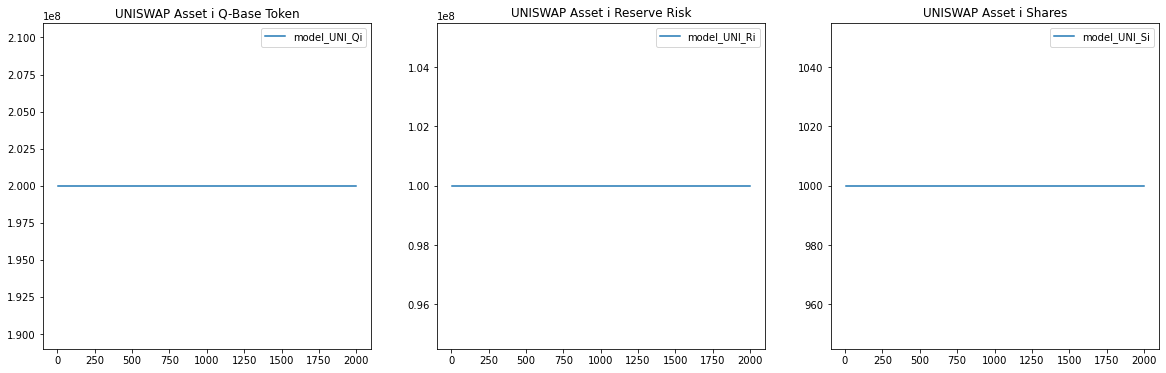

In [9]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Qi'])
plt.title('UNISWAP Asset i Q-Base Token')

ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Ri'])
plt.title('UNISWAP Asset i Reserve Risk')

ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Si'])
plt.title('UNISWAP Asset i Shares')
plt.show()

### Prices of the i-th asset

The following command line creates a plot of the prices: (for the i-th asset)
- the swap price of the risk asset 
- the pool ratio price of the risk asset

Comparison of both plots shows the effects of fees.

For experiments where the price of the asset is affected - for example when it is traded - we expect this price either to rise or fall accordingly. For liquidity adds this price should remain unchanged.

To show other assets the suffix of these commands can be replaced by f.e. `Qj` instead of `Qi`

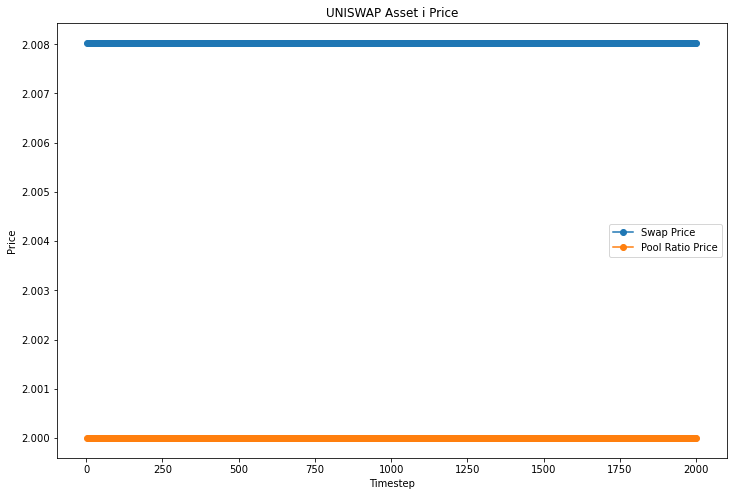

In [10]:
price_plot(rdf,'UNISWAP Asset i Price', 'UNI_P_RQi', 'UNI_Ri', 'UNI_Qi')

## j - Q instance
### Quantities of j-th risk asset, the Q asset and the j-asset shares


The following command lines create three plots that show: (for the j-th asset)
- on the left: the quantity of base asset `UNI_Qj` 
- center: the quantity of risk asset `UNI_Rj`
- on the right: the quantity of shares `UNI_Sj`

over the simulation steps

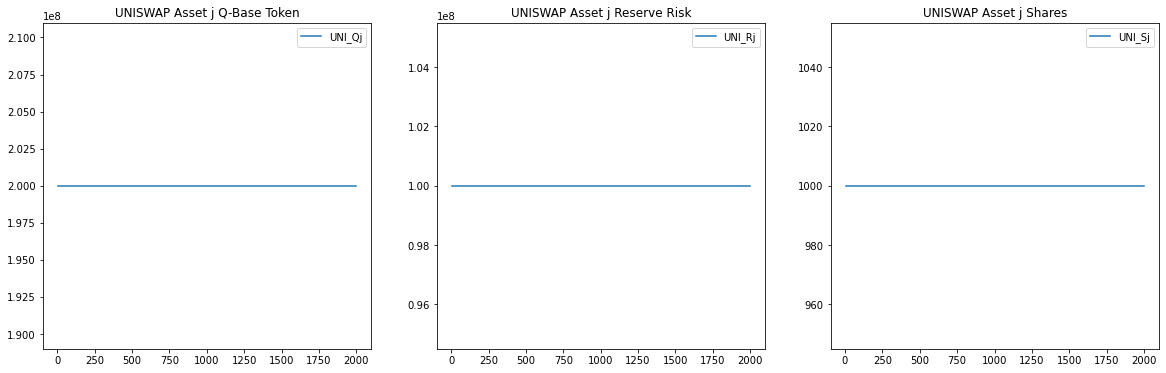

In [11]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Qj'])
plt.title('UNISWAP Asset j Q-Base Token')

ax = plt.subplot(132)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Rj'])
plt.title('UNISWAP Asset j Reserve Risk')

ax = plt.subplot(133)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Sj'])
plt.title('UNISWAP Asset j Shares')
plt.show()

### Prices of the j-th asset

The following command line creates a plot of the prices: (for the j-th asset)
- the swap price of the risk asset 
- the pool ratio price of the risk asset

Comparison of both plots shows the effects of fees.

For experiments where the price of the asset is affected - for example when it is traded - we expect this price either to rise or fall accordingly. For liquidity adds this price should remain unchanged.

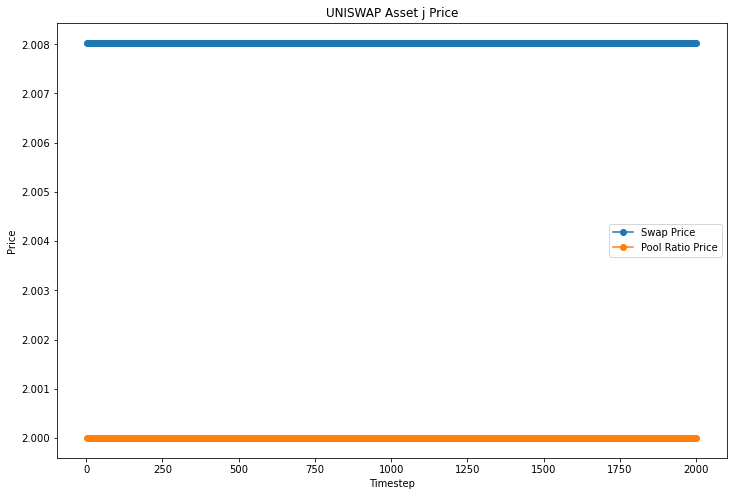

In [12]:
price_plot(rdf,'UNISWAP Asset j Price', 'UNI_P_RQj', 'UNI_Rj', 'UNI_Qj')

## i-j instance
### Quantities of i-th risk asset, the j-th risk asset and the i-j-asset shares


The following command lines create three plots that show: (for the j-th asset)
- on the left: the quantity of the i-th asset `UNI_ij` 
- center: the quantity of the j-th asset `UNI_ji`
- on the right: the quantity of i-j-shares `UNI_Sij`

over the simulation steps

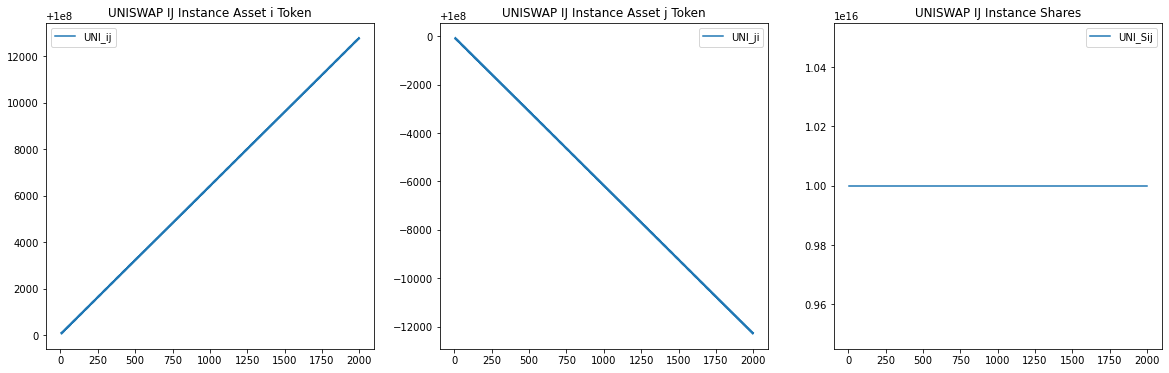

In [13]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_ij'])
plt.title('UNISWAP IJ Instance Asset i Token')

ax = plt.subplot(132)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_ji'])
plt.title('UNISWAP IJ Instance Asset j Token')

ax = plt.subplot(133)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_Sij'])
plt.title('UNISWAP IJ Instance Shares')
plt.show()

### Prices of the i-j asset swap

The following command line creates a plot of the swap prices
- the swap price of the risk asset 
- the pool ratio price of the risk asset

Comparison of both plots shows the effects of fees.

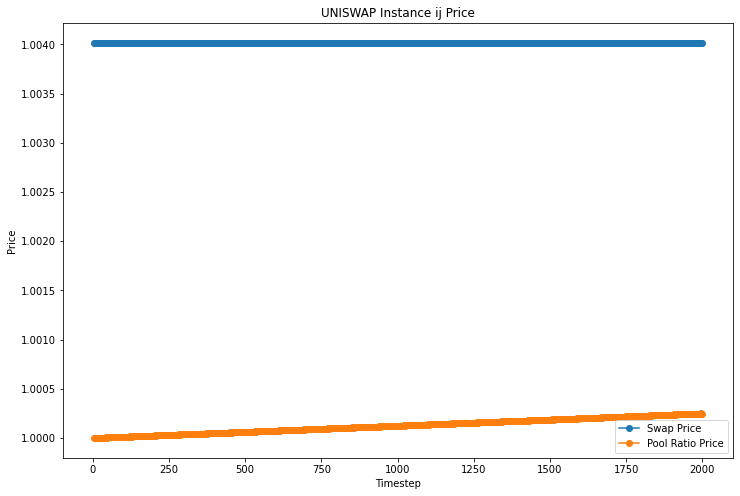

In [14]:
price_plot(rdf,'UNISWAP Instance ij Price', 'UNI_P_ij', 'UNI_ji','UNI_ij' )


## Global State Variables for Hydra instance

The Hydra system state can be described with the following global variables:

| Symbol | Name | Definition  | Domain |  | Unit | | 
| --------|------- | -------- | -------- | -------- | -------- |-------|
| $H$     | HDX Total Supply     | Supply is the total quantity of the native protocol token (HDX).|  ${\mathbb{R}_{++}}$| | HDX; an amount in real positive numbers
| $Q$     | Base Pool Liquidity     | Base Pool Liquidity is the total quantity of the base asset (HDX) inside Pool.|  ${\mathbb{R}_{+}}$| | HDX; a positive real number if a pool has at least one risk asset
| $\mathbf{\vec{R}}$ | Reserve Risk Assets     | An $n$-dimensional vector whose components are quantities of risk assets provided to the Liquidity Pool by liquidity providers.      |  $\mathbb{R}_{++}^{n}$ | | BTC, ETH, DOT,...; a vector of real positive numbers denoting quantities of each asset in the pool.
| $\mathbf{\vec{S}}$     | Asset Shares     | Asset Shares are non-normalized values of each risk asset in the pool which are minted and distributed to the liquidity providers at time of inception of their asset into the Liquidity Pool. |  $\mathbb{R}_{++}^{n}$ | | a vector of real positive numbers
| $S^Q$     | Base Pool Share     | The Pool value share of the base asset (HDX), i.e. claims on $Q$.|  $\mathbb{R}_{+}$ | | HDX; a real positive number if there exists at least one risk asset in the pool
| $\mathbf{\vec{W}}$     | Asset Weights     | Asset Weights are non-normalized values of each risk asset in the pool used in the Uniswap/Balancer mechanisms. |  $\mathbb{R}_{++}^{n}$ | | a vector of real positive numbers
| $W^Q$     | Base Pool Weight     | The non-normalized Pool value weight of the base asset (HDX).|  $\mathbb{R}_{+}$ | | a real positive number
| $\mathbf{{P}}$     | Price    | The Price is a (n+1)x(n+1) Matrix listing all spot prices for all risk assets present in the Liquidity pool. Its components $p_{i,j}$ are the prices of the i-th asset denoted in the j-th asset.| $\mathbb{R}_{++}^{n\times n}$ | | f.e: ETH/HDX; depending on the component $p_{ij}$ of the matrix the unit is currency$_i$ / currency$_j$ where for the above example $i$ is ETH and $j$ is HDX. |
| $\vec{p}^Q$     | Asset Base Price    | The Asset Base Price is a vector listing the spot prices of all risk assets in the pool in terms of the base asset HDX. | $\mathbb{R}^n_{++}$ | | A real number representing the rate of exchange between a risk asset and HDX, e.g. ETH/HDX. |


Notice that $H$, $Q$ and $S^Q$ represent the Base side of the Omnipool and are tracked separately in the Hydra World whereas the other variables representing the Risk side of the Omnipool are encoded in $\mathbf{\vec{R}}$ , $\mathbf{\vec{S}}$  are tracked by the `pool` variable

## Hydra World
### Base Asset side of the Omnipool
### Quantities of the base asset in the pool and in the system, and the base-shares

The following command lines create three plots that show: (for the base asset)
- on the left: the quantity of base asset in the pool `Hydra_Q` 
- center: the total quantity of base asset in the system `Hydra_H` 
- on the right: the quantity of base asset shares `Hydra_Sq`

over the simulation steps

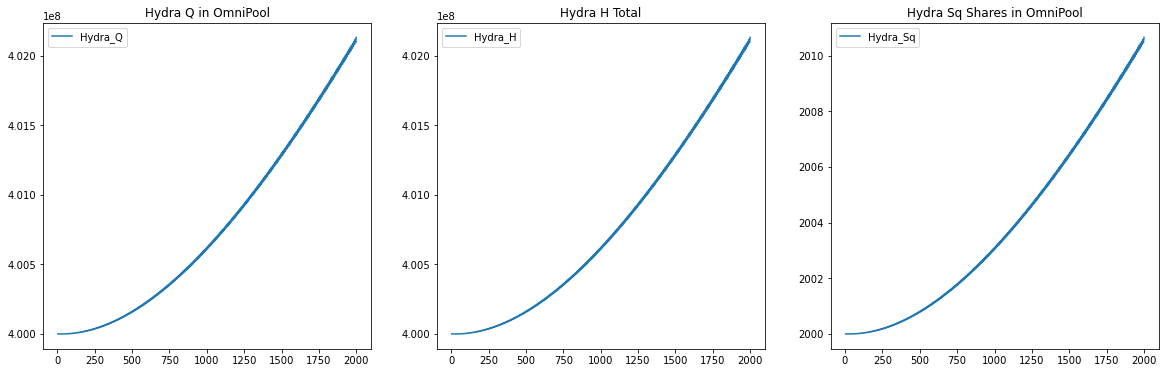

In [15]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
hydra.astype(float).plot(ax=ax, y=['Hydra_Q'])
plt.title('Hydra Q in OmniPool')

ax = plt.subplot(132) 
hydra.astype(float).plot(ax=ax, y=['Hydra_H'])
plt.title('Hydra H Total')

ax = plt.subplot(133)
hydra.astype(float).plot(ax=ax, y=['Hydra_Sq'])
plt.title('Hydra Sq Shares in OmniPool')
plt.show()

## Hydra World
### Risk Asset side of the Omnipool
### Quantities of the i-th risk asset, i-Shares and the price for i

The following command line creates three plots for the Hydra Omnipool (for the i-th asset on the risk side)

- the asset index can be set individually to `i`, `j`, etc.


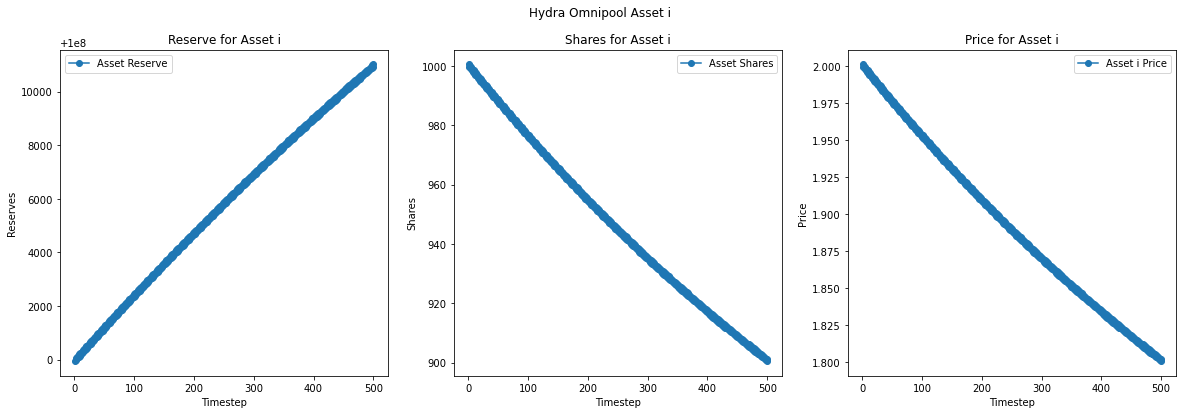

In [16]:
hydra_pool_plot(rdf,'Asset i Reserve and Shares', rdf.last_valid_index(),str('i'))

### Quantities of the j-th risk asset, j-Shares and the price for j

The following command line creates three plots for the Hydra Omnipool 

- the asset index can be set individually to `i`, `j`, etc.


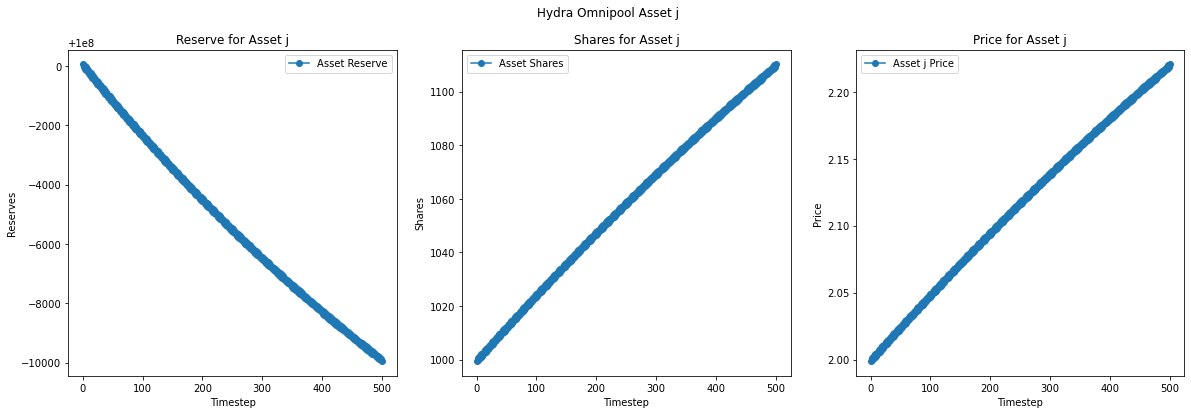

In [17]:
hydra_pool_plot(rdf,'Asset j Reserve and Shares', rdf.last_valid_index(),str('j'))

### Quantities of the k-th risk asset, k-Shares and the price for k

The following command line creates three plots for the Hydra Omnipool 

- the asset index can be set individually to `i`, `j`, etc.

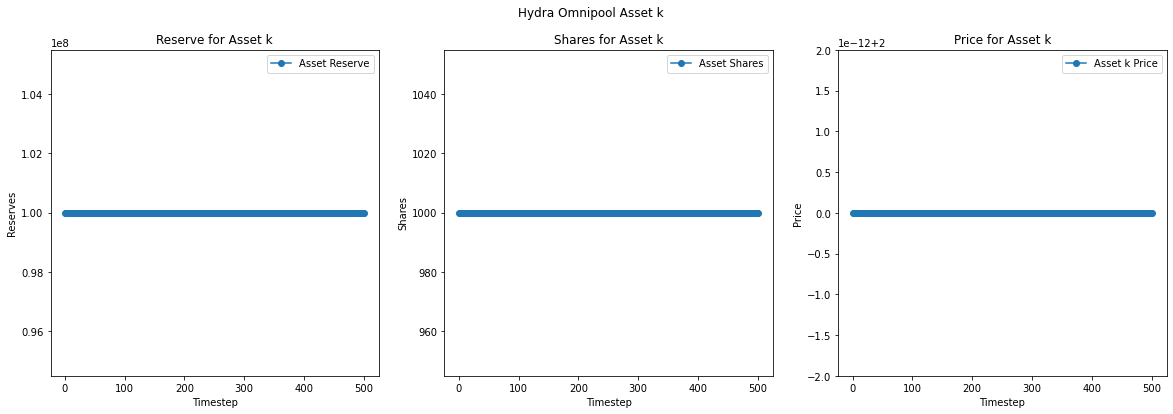

In [18]:
hydra_pool_plot(rdf,'Asset k Reserve and Shares', rdf.last_valid_index(),str('k'))

### Price comparison for assets on the risk side of the Omnipool

The following command lines create a plots for the Hydra Omnipool prices:
- Asset Base Prices
- Share to Reserve Ratio Base Prices
- Relative Asset Prices `i` to `j`
- Relative Asset Prices `i` to `k`
- Relative Asset Prices `j` to `k`

    

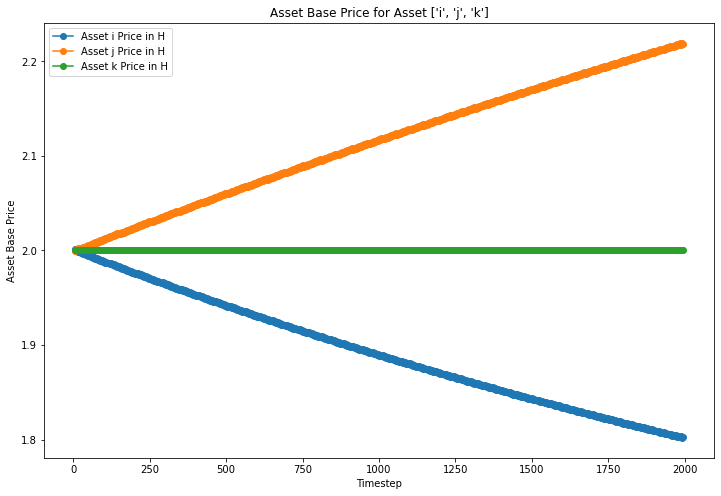

In [19]:
hydra_pool_price_plot(rdf,'Asset Base Price', rdf.last_valid_index(),['i', 'j','k'])

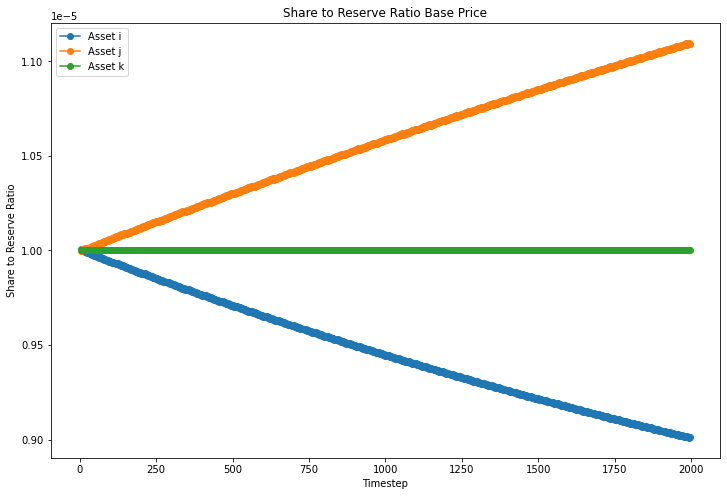

In [20]:
trade_liq_plot(rdf,'Share to Reserve Ratio Base Price', rdf.last_valid_index(),['i', 'j','k'])

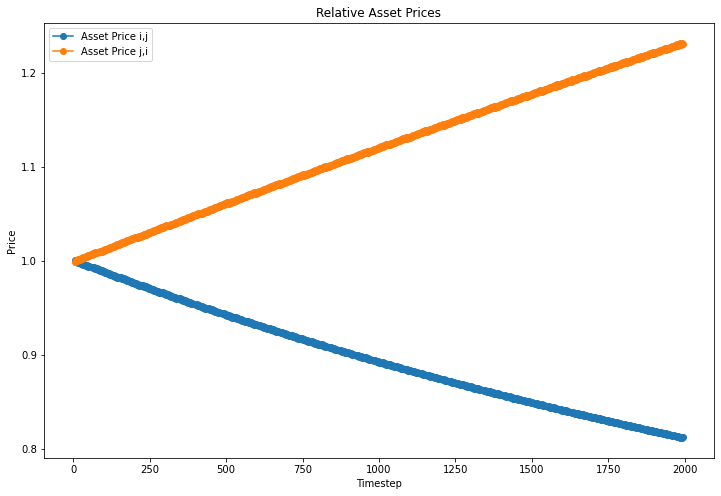

In [21]:
rel_price_plot(rdf,'Relative Asset Prices', rdf.last_valid_index(),['i', 'j'])

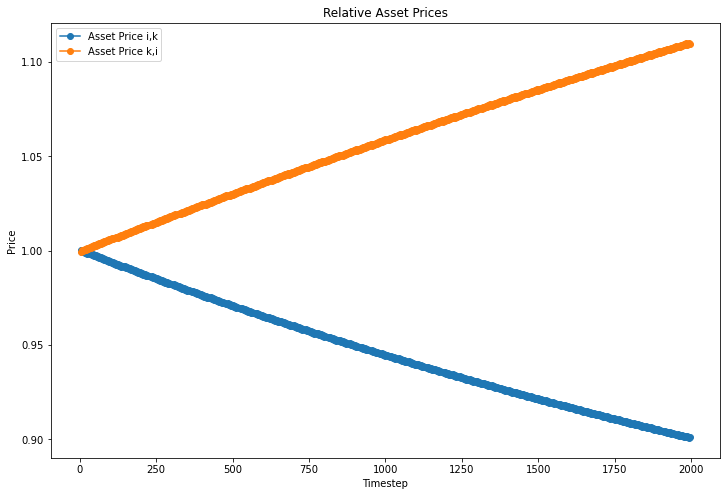

In [22]:
rel_price_plot(rdf,'Relative Asset Prices', rdf.last_valid_index(),['i', 'k'])

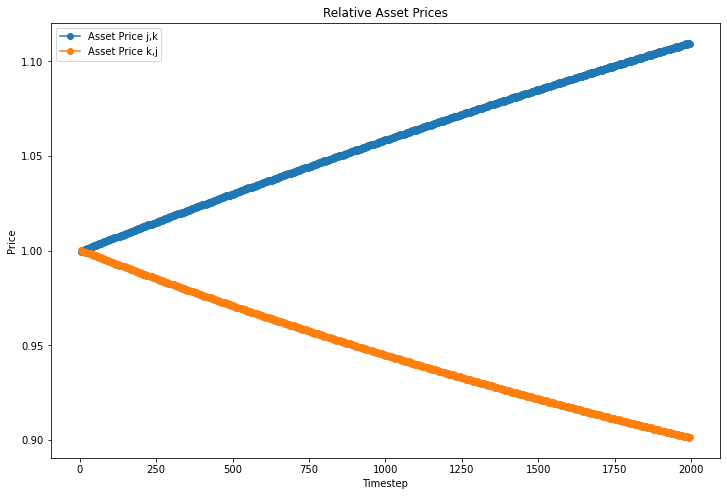

In [23]:
rel_price_plot(rdf,'Relative Asset Prices', rdf.last_valid_index(),['j', 'k'])


# Agents and their Local State Variables

The following section tracks the development for the agent states.
As every agent is defined to be responsible for a different action and all agent states are shown this section can be used to assess 
- the intentional changes in the local states directly affected by the actions, and
- the unintentional changes in local states of other agents who are indirectly affected

All agents carry the following local states:

| Symbol | Name | Definition  | Domain |   | Unit
| -------- | -------- | -------- | -------- | -------- | --------|
| $\mathbf{r}^j$     | Reserve Assets     | Reserve Assets are quantities of privately held risk assets by liquidity provider agent $j$ which are not (yet) related to the Liquidity Pool. |  $\mathbb{R}_{+}^{n}$| | BTC, ETH, DOT,...; an amount in real non-negative numbers denoted in the respective currency unit
| $h^j$     | Base Asset     | Total Base Asset (HDX) amount of $H$ held by agent $j$. |  $\mathbb{R}_{+}$| | a real non-negative amount of HDX |
| $\mathbf{s}^j$     | Risk Asset Shares     | Risk Asset Share as value of liquidity provider agent $j$'s contribution of risk asset(s) to the Liquidity Pool, minted and distributed (as a claim) to agent $j$ at the time of introduction into the Pool.| $\mathbb{R}_{+}^{n}$  | |a vector of amounts in real non-negative numbers
| $s^{qj}$     | Base Asset Share     | Base Asset (HDX) share as value of liquidity provider agent $j$'s contribution of HDX to the Liquidity Pool,  minted and distributed to agent $j$ (as a claim) at the time of introduction into the Pool.| $\mathbb{R}_{+}$  | |a real non-negative number

To locate specific values in the dataframe the commands
- `first_valid_index()`
- `first_valid_index()*x`
- `last_valid_index()`

can be used.


## Hydra World

Results for the copy of the agents going through the Hydra world are saved in `hydra_agents`


In [24]:
rdf['hydra_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,10.00,100000.00,0.00,0.00,0.00,7.00,100.00,0.00,0.00
1,1.00,999900.00,20.00,10000.00,0.00,0.00,0.00,107.00,200.00,0.00,0.00
2,2.00,100000.00,30.00,100000.00,0.00,0.00,0.00,100000.00,300.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,9.00,400.00,0.00,1000000000.00
4,4.00,1.00,0.00,10000.00,0.00,0.00,0.00,1000000.00,500.00,0.00,0.00
5,5.00,51.85,0.00,100000.00,0.00,0.00,0.00,99950.00,600.00,0.00,0.00
6,6.00,3.00,0.00,1000000.00,0.00,0.00,0.00,100000.00,700.00,0.00,0.00
7,7.00,4.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


In [25]:
rdf['hydra_agents'][rdf.first_valid_index()*10]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,10.00,100000.00,0.00,0.00,0.00,7.00,100.00,0.00,0.00
1,1.00,999000.00,20.00,10000.00,0.00,0.00,0.00,1001.00,200.00,0.00,0.00
2,2.00,100000.00,30.00,100000.00,0.00,0.00,0.00,100000.00,300.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,9.00,400.00,0.00,1000000000.00
4,4.00,1.00,0.00,10000.00,0.00,0.00,0.00,1000000.00,500.00,0.00,0.00
5,5.00,496.75,0.00,100000.00,0.00,0.00,0.00,99500.00,600.00,0.00,0.00
6,6.00,3.00,0.00,1000000.00,0.00,0.00,0.00,100000.00,700.00,0.00,0.00
7,7.00,4.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


## Uniswap world

Results for the copy of the agents going through the Hydra world are saved in `uni_agents`

In [26]:
rdf['uni_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,10.00,100000.00,0.00,0.00,0.00,7.00,100.00,0.00,0.00
1,1.00,999900.00,20.00,10000.00,0.00,0.00,0.00,107.00,200.00,0.00,0.00
2,2.00,100000.00,30.00,100000.00,0.00,0.00,0.00,100000.00,300.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,9.00,400.00,0.00,1000000000.00
4,4.00,1.00,0.00,10000.00,0.00,0.00,0.00,1000000.00,500.00,0.00,0.00
5,5.00,51.85,0.00,100000.00,0.00,0.00,0.00,99950.00,600.00,0.00,0.00
6,6.00,3.00,0.00,1000000.00,0.00,0.00,0.00,100000.00,700.00,0.00,0.00
7,7.00,4.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


In [27]:
rdf['uni_agents'][rdf.first_valid_index()*10]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,10.00,100000.00,0.00,0.00,0.00,7.00,100.00,0.00,0.00
1,1.00,999000.00,20.00,10000.00,0.00,0.00,0.00,1001.00,200.00,0.00,0.00
2,2.00,100000.00,30.00,100000.00,0.00,0.00,0.00,100000.00,300.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,9.00,400.00,0.00,1000000000.00
4,4.00,1.00,0.00,10000.00,0.00,0.00,0.00,1000000.00,500.00,0.00,0.00
5,5.00,496.75,0.00,100000.00,0.00,0.00,0.00,99500.00,600.00,0.00,0.00
6,6.00,3.00,0.00,1000000.00,0.00,0.00,0.00,100000.00,700.00,0.00,0.00
7,7.00,4.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


## Agent Token Holdings - Uniswap World


The following command line creates eight plots, one for each agent individually, showing his token holdings 


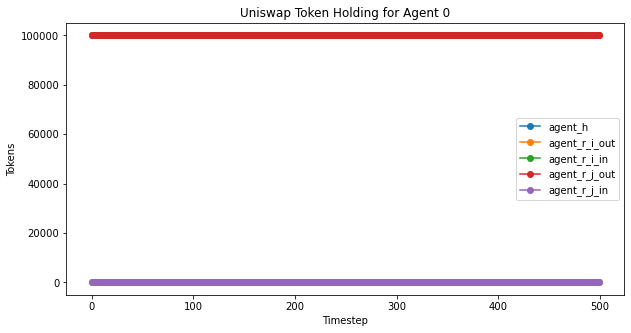

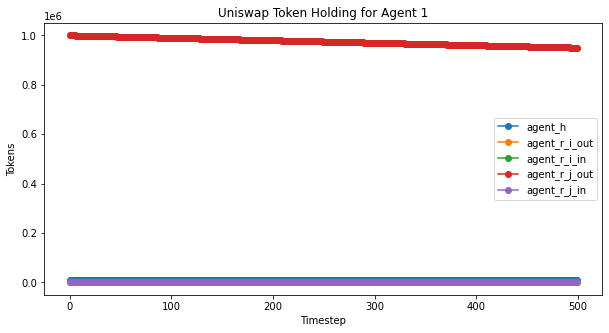

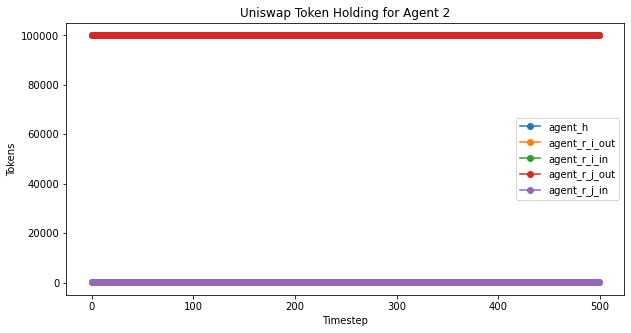

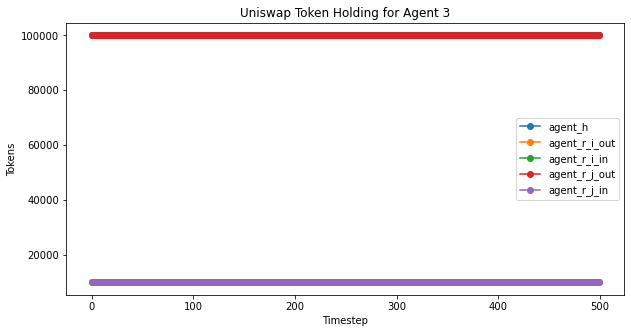

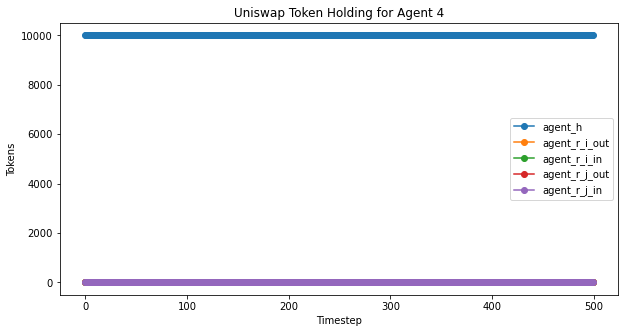

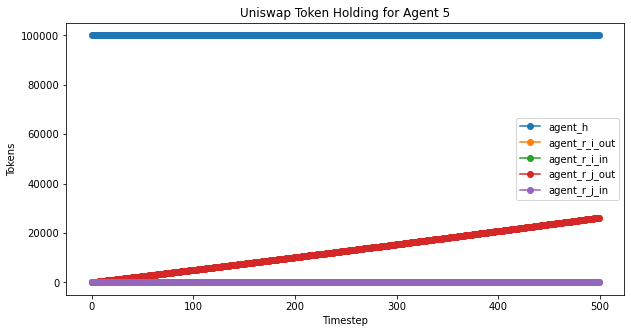

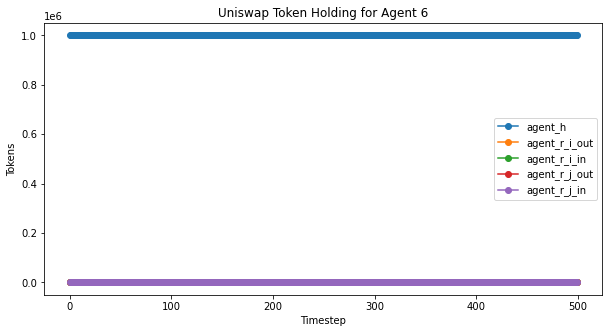

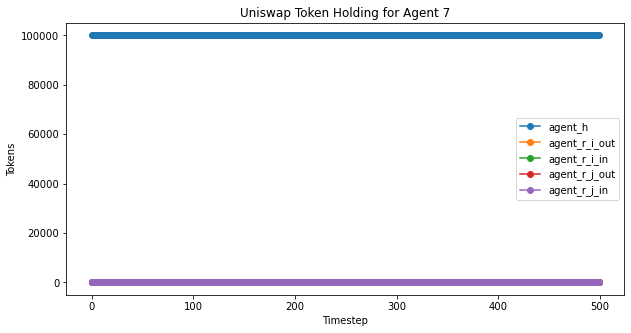

In [28]:
agent_plot(rdf,'Uniswap Token Holding for Agent ', len(rdf['timestep'])) #,4,'j')

## Agent Values - Uniswap World

The following command line creates eight plots, one for each agents showing his values. These are the token holdings multiplied by price.
  



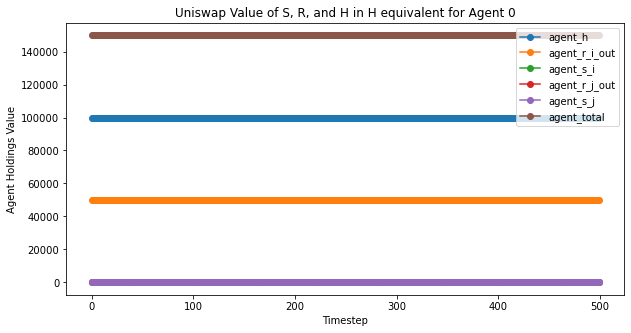

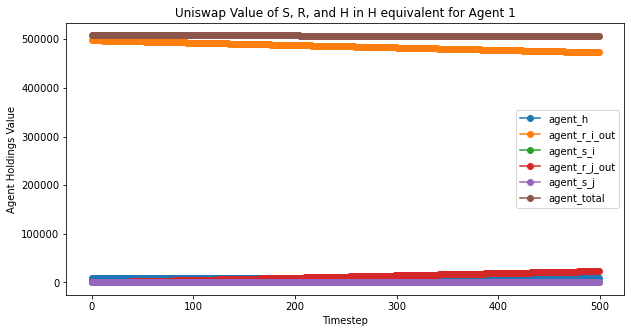

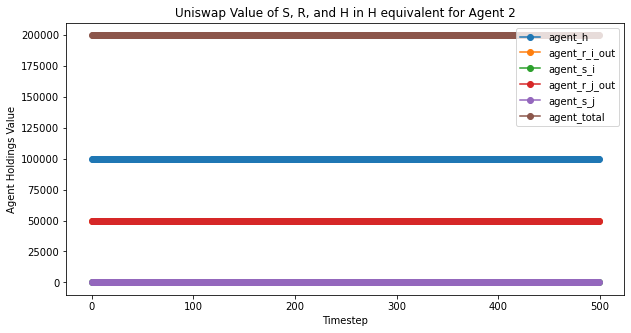

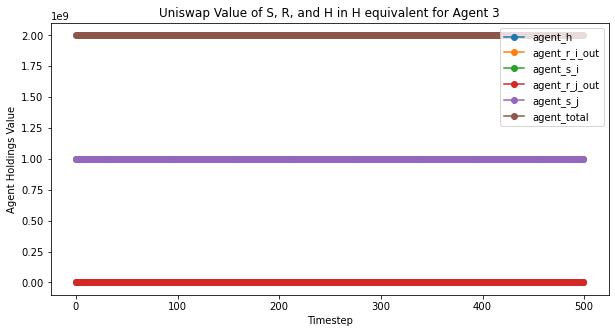

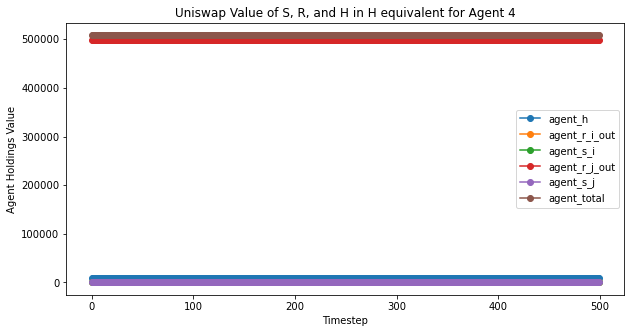

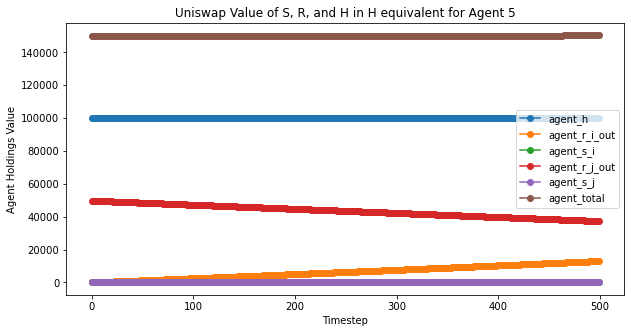

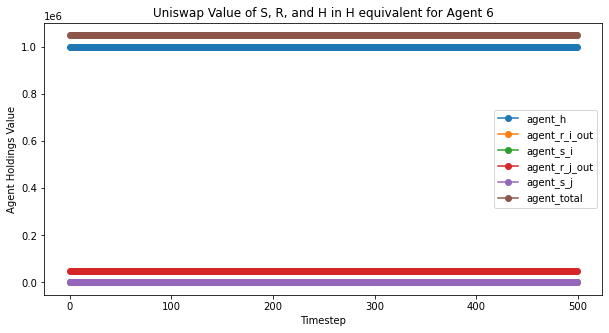

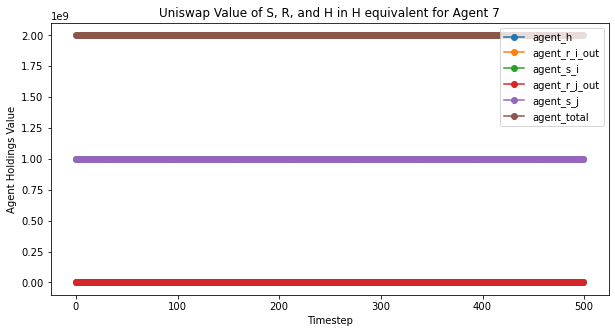

In [29]:
agent_value_plot(rdf,'Uniswap Value of S, R, and H in H equivalent', len(rdf['timestep'])) #,2, 'i')

## Agent Token Holdings - Hydra World

The following command line creates eight plots, one for each agents indivudially, showing his token holdings


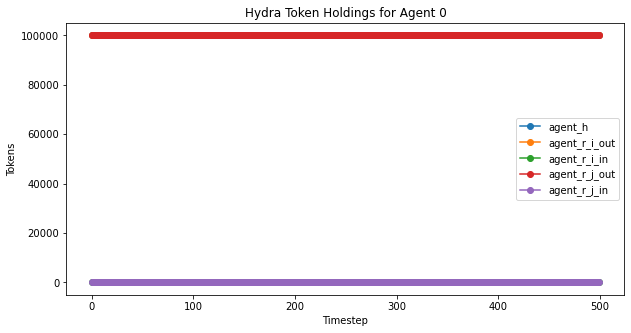

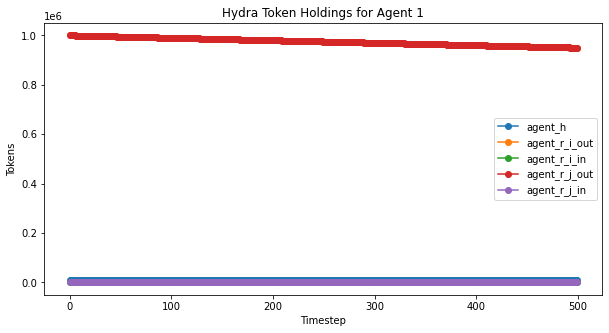

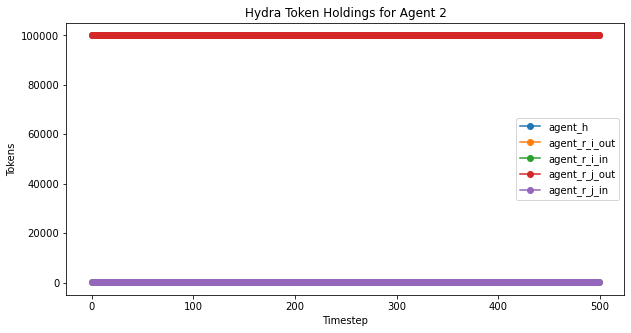

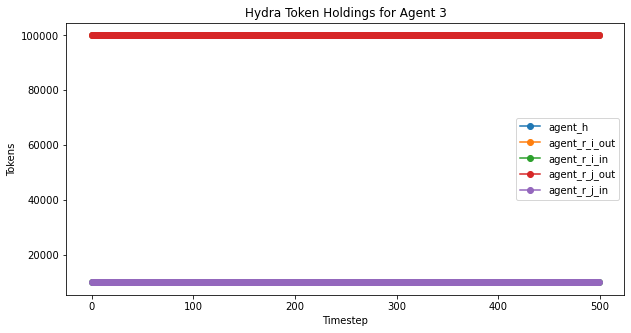

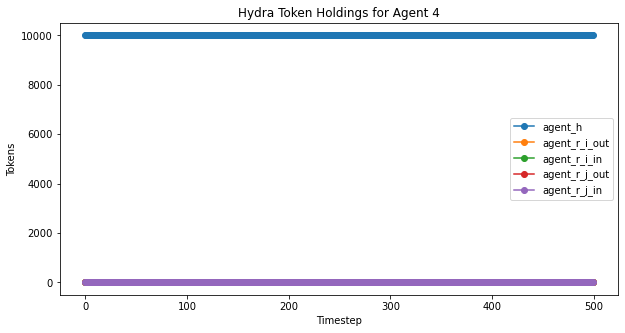

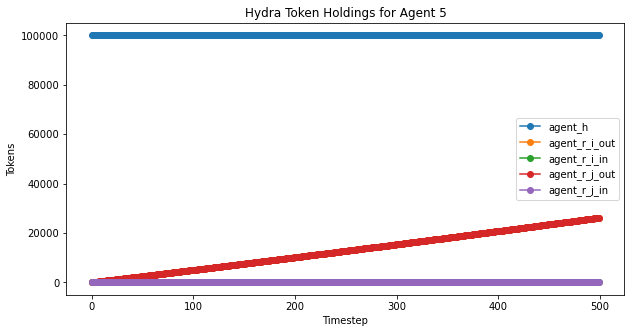

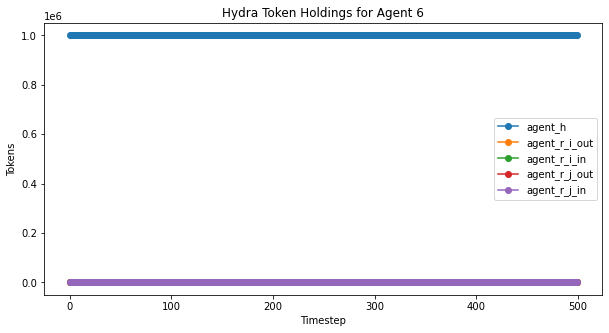

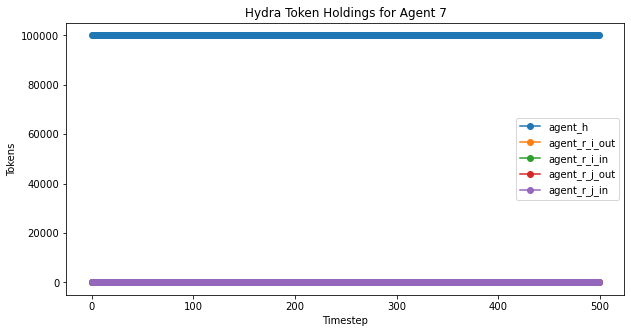

In [30]:
hydra_agent_plot(rdf,'Hydra Token Holdings for Agent ', len(rdf['timestep']))

## Agent Values - Hydra World

The following command line creates eight plots, one for each agents showing his values. These are the token holdings multiplied by price.


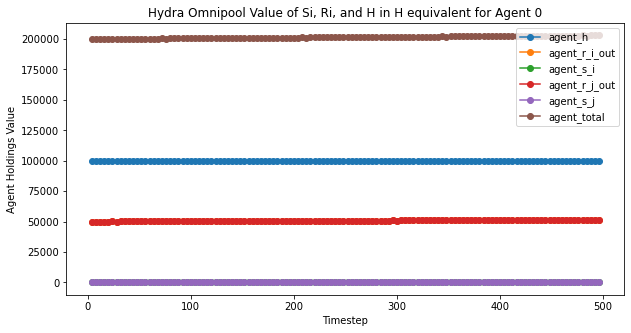

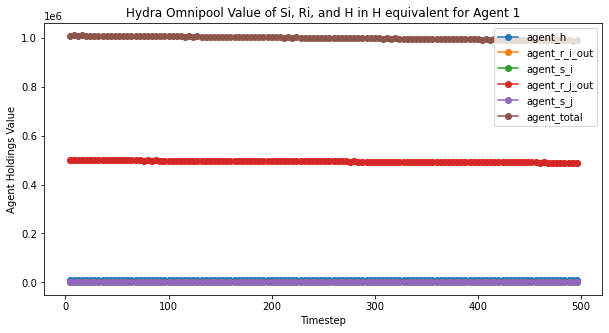

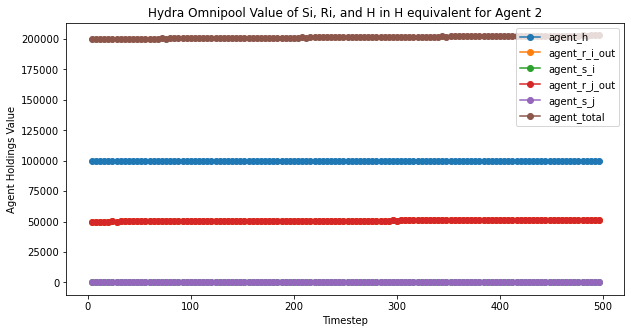

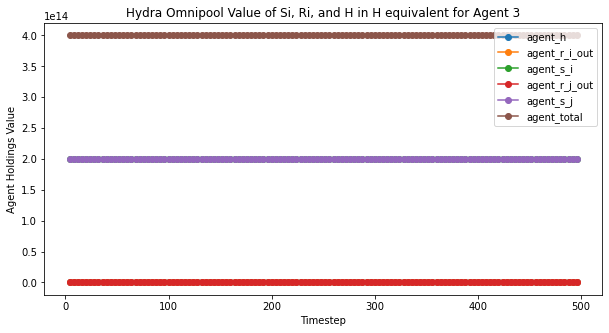

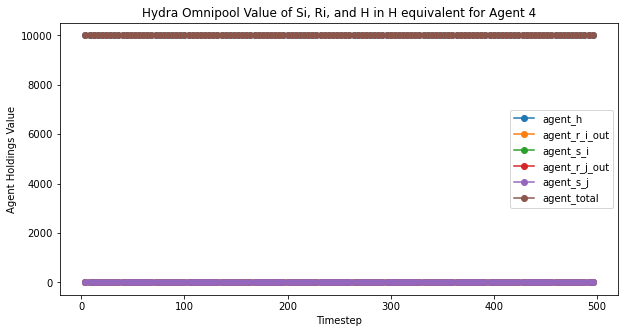

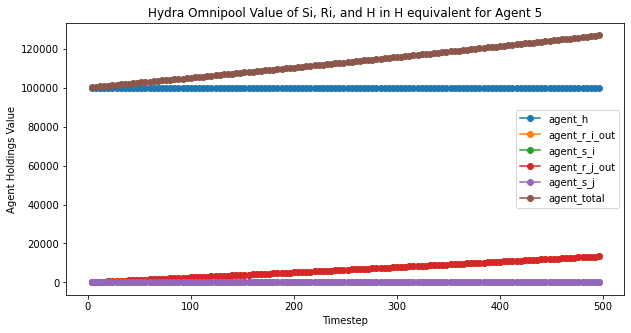

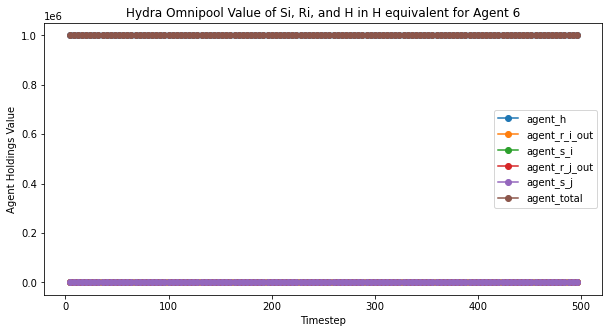

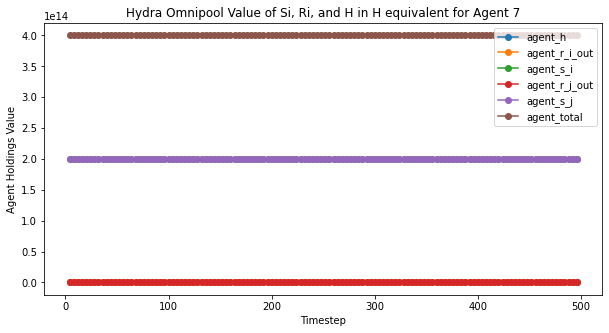

In [31]:
hydra_agent_value_plot(rdf,'Hydra Omnipool Value of Si, Ri, and H in H equivalent', len(rdf['timestep'])) #,2, 'i')

# Impermanent Loss (IL) calculation

Impermanent loss is defined as 

$$
IL = \frac{\delta Pool Value}{\delta Hold Value} - 1
$$


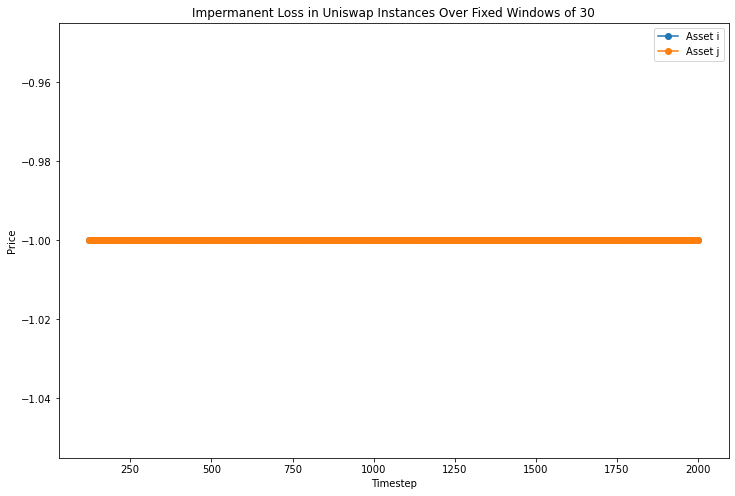

In [32]:
IL_plot(rdf,'Impermanent Loss in Uniswap Instances Over Fixed Windows of ', 30)

### Impermanent Loss assessment for an agent who provides assets to the Hydra Omnipool

- Compare results of the experiments to
- A simple calculation of holding assets outside the pool

We will need $V_{hold}$ and $V_{pool}$ and to compute IL we will compare both values



#### To compute $V_{pool}$:
- Take the agent holdings and multiply by prices to get the market value of the agent portfolio $V_{0}$
- Assume that prices will change from $t_0$ to $t_1$
- Take the agent holdings and multiply by new prices $p'$ to get the new pool value $V_{1}$ of the agent portfolio

The holdings can be taken directly from the `state_variables.py` file as these are the initialized values. For the prices we will take the updated asset prices from the simulation.

Prices of assets in the pool are stored in the class `Asset()` and can be called:

In [33]:
rdf.pool[rdf.last_valid_index()].pool

{'i': {'R': 100011011.20568588,
  'S': 900.5624464780909,
  'W': 900.5624464780909,
  'P': 1.8009265892251927,
  'dP': -0.0016263993684517697},
 'j': {'R': 99990055.35026518,
  'S': 1110.0903673494342,
  'W': 1110.0903673494342,
  'P': 2.220401545855313,
  'dP': 0.002001196446885789},
 'k': {'R': 100000000,
  'S': 1000,
  'W': 1000,
  'P': 2.000000000000002,
  'dP': 0.0}}

To access the price of any risk asset in the pool this command line can be used:
- Changing `i` to a different index will return the respective asset price

In [34]:
rdf.pool[rdf.last_valid_index()].pool['i']['P']

1.8009265892251927

The agent holdings can be called as:

`df.hydra_agents.values[i]['h'][agent_index]`

where:
- `i` is the timestep ranging from (0,T) and is defined in the `config.py` as `T` but includes all substeps and therefore has to be multiplied by 4
- `h` is the asset identifier
- `agent_index` ranges from 0 to 7

In [35]:
df.hydra_agents.values[2000]['r_i_in'][1]

20.0

If we define the market value of the agent portfolio as
$$
V_0 = \sum_{n} r_n^0 \cdot p_n
$$

for asset quantities and prices at $t_0$ and we restrict the portfolio to only contain $r_i$ and $r_j$ and no other assets we can calculate this as:

In [36]:
V_0 = df.hydra_agents.values[0]['r_i_in'][0] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_in'][0] * rdf.pool[rdf.first_valid_index()].pool['j']['P']
V_0

219.90991005505495

for $t_1$ this is the same with the updated prices $p'$

$$
V_1 = \sum_{n} r_n^1 \cdot p_n'
$$

In [37]:
V_1 = df.hydra_agents.values[2000]['r_i_in'][0] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[2000]['r_j_in'][0] * rdf.pool[rdf.last_valid_index()].pool['j']['P']
V_1

240.0494204777832

Therefore the change in his pool value $V_p$ calculates as
$$
\Delta V_p = V_1 - V_0
$$

In [38]:
DeltaPool = V_1 - V_0
DeltaPool

20.13951042272825

#### To compute $V_{hold}$

- Take the agent initial holdings and multiply by initial prices to get the initial value $\bar{V}_0$ (this should be the same as in the case above)
- assume that prices change from $t_0$ to $t_1$ **but the quantities of agent holdings will remain the same**
- Take therefore the initial holdings and multiply by updated prices $p'$ to get to the value $\bar{V}_1$

Consequently we define

$$
\bar{V}_0 = \sum_{n} r_n^0 \cdot p_n
$$

and

$$
\bar{V}_1 = \sum_{n} r_n^0 \cdot p_n'
$$

to get to the change in $V_{hold}$ as
$$
\Delta V_{hold} = \bar{V}_1 - \bar{V}_0
$$


In [39]:
Vbar_0 = df.hydra_agents.values[0]['r_i_in'][0] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_in'][0] * rdf.pool[rdf.first_valid_index()].pool['j']['P']
Vbar_0

219.90991005505495

In [40]:
Vbar_1 = df.hydra_agents.values[0]['r_i_in'][0] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_in'][0] * rdf.pool[rdf.last_valid_index()].pool['j']['P']
Vbar_1

240.0494204777832

In [41]:
DeltaHold = Vbar_1 - Vbar_0
DeltaHold

20.13951042272825

Ultimately the **Impermanent Loss** can be expressed as 
$$
IL = \frac{\Delta V_{pool}}{\Delta V_{hold}} - 1
$$

and calculated as:

In [42]:
IL = DeltaPool / DeltaHold - 1
IL

0.0

In [43]:
df.hydra_agents.values

array([   m  r_i_out  r_i_in        h    q_i         s_i  s_q  r_j_out  r_j_in  \
0  0   100000      10   100000      0           0    0        7     100   
1  1  1000000      20    10000      0           0    0        8     200   
2  2   100000      30   100000      0           0    0   100000     300   
3  3   100000   10000   100000  10000  1000000000    0        9     400   
4  4        1       0    10000      0           0    0  1000000     500   
5  5        2       0   100000      0           0    0   100000     600   
6  6        3       0  1000000      0           0    0   100000     700   
7  7        4       0   100000      0  1000000000    0   100000   10000   

     q_j         s_j  
0      0           0  
1      0           0  
2      0           0  
3      0  1000000000  
4      0           0  
5      0           0  
6      0           0  
7  10000  1000000000  ,
            m   r_i_out   r_i_in          h      q_i           s_i  s_q    r_j_out  \
0 0.00 100000.00    10.

In [44]:
agent_V_0_list = []
for i in range(0, 7, 1):
    agent_V_0_list.append(df.hydra_agents.values[0]['r_i_in'][i] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_in'][i] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
agent_V_0_list

[219.90991005505495,
 439.8198201101099,
 659.7297301651648,
 20809.6096052052,
 999.4995002502498,
 1199.3994003002997,
 1399.2993003503498]

In [45]:
agent_V_0_list = []
number_of_agents = 8
for agent_index in range(number_of_agents):
    agent_V_0_list.append(df.hydra_agents.values[0]['r_i_in'][agent_index] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_in'][agent_index] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
agent_V_0_list

[219.90991005505495,
 439.8198201101099,
 659.7297301651648,
 20809.6096052052,
 999.4995002502498,
 1199.3994003002997,
 1399.2993003503498,
 19989.990005004995]

In [46]:
agent_V_1_list = []

time = 2000

for i in range(0, 8, 1):
    agent_V_1_list.append(df.hydra_agents.values[time]['r_i_in'][i] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[time]['r_j_in'][i] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
agent_V_1_list

[240.0494204777832,
 480.0988409555664,
 720.1482614333496,
 18897.42651059405,
 1110.2007729276563,
 1332.2409275131877,
 1554.281082098719,
 22204.015458553127]

In [47]:
agent_delta_list = np.subtract(agent_V_1_list,agent_V_0_list)
agent_delta_list

array([   20.13951042,    40.27902085,    60.41853127, -1912.18309461,
         110.70127268,   132.84152721,   154.98178175,  2214.02545355])

In [48]:
agent0_V_0_list = []
time = 2000
for t in range(0, time, 1):
    agent0_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][5] * rdf.pool[rdf.first_valid_index() + 4].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][5] * rdf.pool[rdf.first_valid_index() + 4].pool['j']['P'])
agent0_V_0_list

[200104.0982944487,
 200104.0982944487,
 200103.69819501915,
 200103.69819501915,
 200103.69819501915,
 200101.59899781994,
 200101.59899781994,
 200101.59899781994,
 200101.59899781994,
 200101.59899781994,
 200101.29879789846,
 200101.29879789846,
 200101.29879789846,
 200099.19960069927,
 200099.19960069927,
 200099.19960069927,
 200099.19960069927,
 200099.19960069927,
 200098.99925017866,
 200098.99925017866,
 200098.99925017866,
 200096.90005297947,
 200096.90005297947,
 200096.90005297947,
 200096.90005297947,
 200096.90005297947,
 200096.79950164145,
 200096.79950164145,
 200096.79950164145,
 200094.70030444226,
 200094.70030444226,
 200094.70030444226,
 200094.70030444226,
 200094.70030444226,
 200094.6995019573,
 200094.6995019573,
 200094.6995019573,
 200092.60030475812,
 200092.60030475812,
 200092.60030475812,
 200092.60030475812,
 200092.60030475812,
 200092.69920068557,
 200092.69920068557,
 200092.69920068557,
 200090.60000348635,
 200090.60000348635,
 200090.6000034863

Text(0, 0.5, 'Agent 0 V_0')

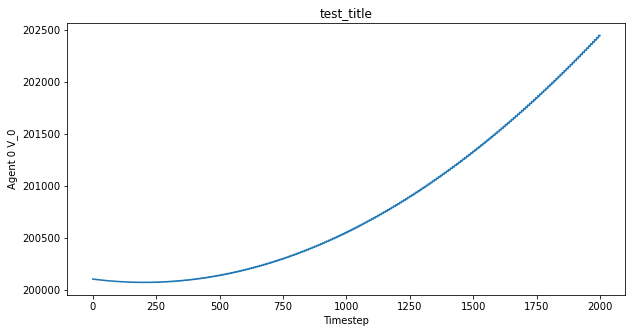

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(range(0,2000,1), agent0_V_0_list)
plt.title('test_title')
plt.xlabel('Timestep')
plt.ylabel('Agent 0 V_0')

Text(0, 0.5, 'Agent 0 V_0')

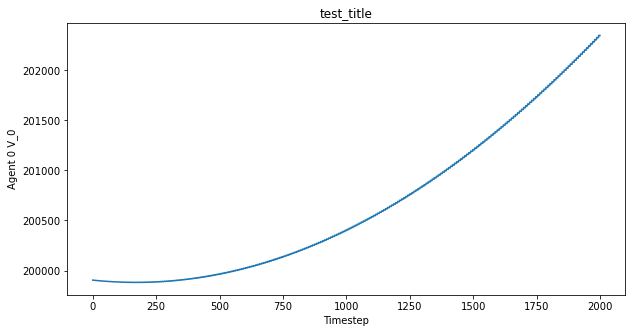

In [50]:
agent5_V_0_list = []

time = 2000
for t in range(0, time, 1):
        agent5_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][5] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][5] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])


plt.figure(figsize=(10, 5))
plt.plot(range(0,2000,1), agent5_V_0_list)
plt.title('test_title')
plt.xlabel('Timestep')
plt.ylabel('Agent 0 V_0')

In [51]:
rdf.first_valid_index()+(4*t)

8000

In [52]:
agent0_V_0_list = []
agent1_V_0_list = []
agent2_V_0_list = []
agent3_V_0_list = []
agent4_V_0_list = []
agent5_V_0_list = []
agent6_V_0_list = []
agent7_V_0_list = []

time = 2000
for t in range(0, time, time - 1):
    agent0_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][0] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][0] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent1_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][1] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][1] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent2_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][2] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][2] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent3_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][3] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][3] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent4_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][4] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][4] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent5_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][5] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][5] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent6_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][6] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][6] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])
    agent7_V_0_list.append(df.hydra_agents.values[t]['r_i_out'][7] * rdf.pool[rdf.first_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][7] * rdf.pool[rdf.first_valid_index()].pool['j']['P'])


agent1_V_0_list
agent5_V_0_list

[199903.90205205098, 202348.7911681393]

In [53]:
agent0_V_1_list = []
agent1_V_1_list = []
agent2_V_1_list = []
agent3_V_1_list = []
agent4_V_1_list = []
agent5_V_1_list = []
agent6_V_1_list = []
agent7_V_1_list = []

time = 2000
for t in range(0, time, time - 1):
    agent0_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][0] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][0] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent1_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][1] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][1] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent2_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][2] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][2] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent3_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][3] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][3] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent4_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][4] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][4] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent5_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][5] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][5] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent6_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][6] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][6] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent7_V_1_list.append(df.hydra_agents.values[t]['r_i_out'][7] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[t]['r_j_out'][7] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])


agent1_V_1_list
agent5_V_1_list

[222043.75643870974, 213712.26847228972]

In [54]:
agent0_V_1_bar_list = []
agent1_V_1_bar_list = []
agent2_V_1_bar_list = []
agent3_V_1_bar_list = []
agent4_V_1_bar_list = []
agent5_V_1_bar_list = []
agent6_V_1_bar_list = []
agent7_V_1_bar_list = []

time = 2000
for t in range(0, time, time - 1):
    agent0_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][0] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][0] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent1_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][1] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][1] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent2_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][2] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][2] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent3_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][3] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][3] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent4_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][4] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][4] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent5_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][5] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][5] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent6_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][6] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][6] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])
    agent7_V_1_bar_list.append(df.hydra_agents.values[0]['r_i_out'][7] * rdf.pool[rdf.last_valid_index()].pool['i']['P'] + df.hydra_agents.values[0]['r_j_out'][7] * rdf.pool[rdf.last_valid_index()].pool['j']['P'])


agent1_V_1_bar_list
agent5_V_1_bar_list

[222043.75643870974, 222043.75643870974]

In [55]:
agent0_IL = ((agent0_V_1_list[1] - agent0_V_0_list[0] ) / (agent0_V_1_bar_list[1] - agent0_V_0_list[0]) ) - 1
agent1_IL = ((agent1_V_1_list[1] - agent1_V_0_list[0] ) / (agent1_V_1_bar_list[1] - agent1_V_0_list[0]) ) - 1
agent2_IL = ((agent2_V_1_list[1] - agent2_V_0_list[0] ) / (agent2_V_1_bar_list[1] - agent2_V_0_list[0]) ) - 1
agent3_IL = ((agent3_V_1_list[1] - agent3_V_0_list[0] ) / (agent3_V_1_bar_list[1] - agent3_V_0_list[0]) ) - 1
agent4_IL = ((agent4_V_1_list[1] - agent4_V_0_list[0] ) / (agent4_V_1_bar_list[1] - agent4_V_0_list[0]) ) - 1
agent5_IL = ((agent5_V_1_list[1] - agent5_V_0_list[0] ) / (agent5_V_1_bar_list[1] - agent5_V_0_list[0]) ) - 1
agent6_IL = ((agent6_V_1_list[1] - agent6_V_0_list[0] ) / (agent6_V_1_bar_list[1] - agent6_V_0_list[0]) ) - 1
agent7_IL = ((agent7_V_1_list[1] - agent7_V_0_list[0] ) / (agent7_V_1_bar_list[1] - agent7_V_0_list[0]) ) - 1

agents_IL = [agent0_IL, agent1_IL, agent2_IL, agent3_IL, agent4_IL, agent5_IL, agent6_IL, agent7_IL]

agents_IL

[0.0, -0.07294944612084897, 0.0, 0.0, 0.0, -0.37631177788777503, 0.0, 0.0]